In [1]:
import dicom2nifti
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import SimpleITK as sitk # para calcular rangos
import numpy as np
import io
from PIL import Image
import random
from nilearn.image import resample_img

In [2]:
brain_vol = nib.load('ADNI-Full-PostProc/ADNI-10/016_S_4902/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-09-27_10_35_01.0/I337880/ADNI_016_S_4902_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20121003095425916_82_S168893_I337880.nii')
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [3]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'016_S_4902'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 160 160  96   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 0.  0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 160.0
qoffset_y       : 160.0
qoffset_z       : 1.5
srow_x          : [0. 0. 0. 

In [4]:
brain_vol_data = brain_vol.get_fdata()
type(brain_vol_data)

numpy.memmap

In [5]:
brain_vol_data.shape

(160, 160, 96, 1)

In [6]:
brain_vol_data

memmap([[[[0.00000000e+00],
          [0.00000000e+00],
          [1.80664996e-04],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],

         [[0.00000000e+00],
          [0.00000000e+00],
          [2.89063988e-04],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],

         [[0.00000000e+00],
          [0.00000000e+00],
          [1.84278295e-03],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],

         ...,

         [[0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],

         [[0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00],
          ...,
          [0.00000000e+00],
          [0.00000000e+00],
          [0.00000000e+00]],

         [[0.00000000e+00],
          [0.00000000e+00],
    

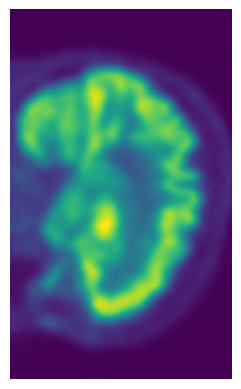

In [7]:
plt.imshow(brain_vol_data[96])
plt.axis('off')
plt.show()

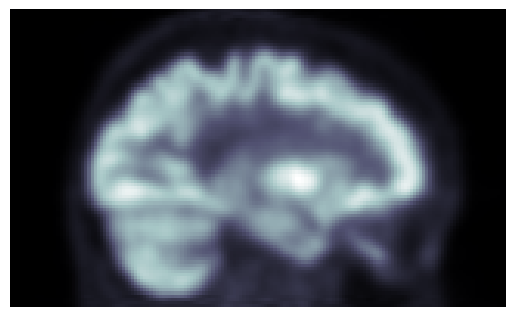

In [8]:
plt.imshow(ndi.rotate(brain_vol_data[96], 90), cmap='bone')
plt.axis('off')
plt.show()

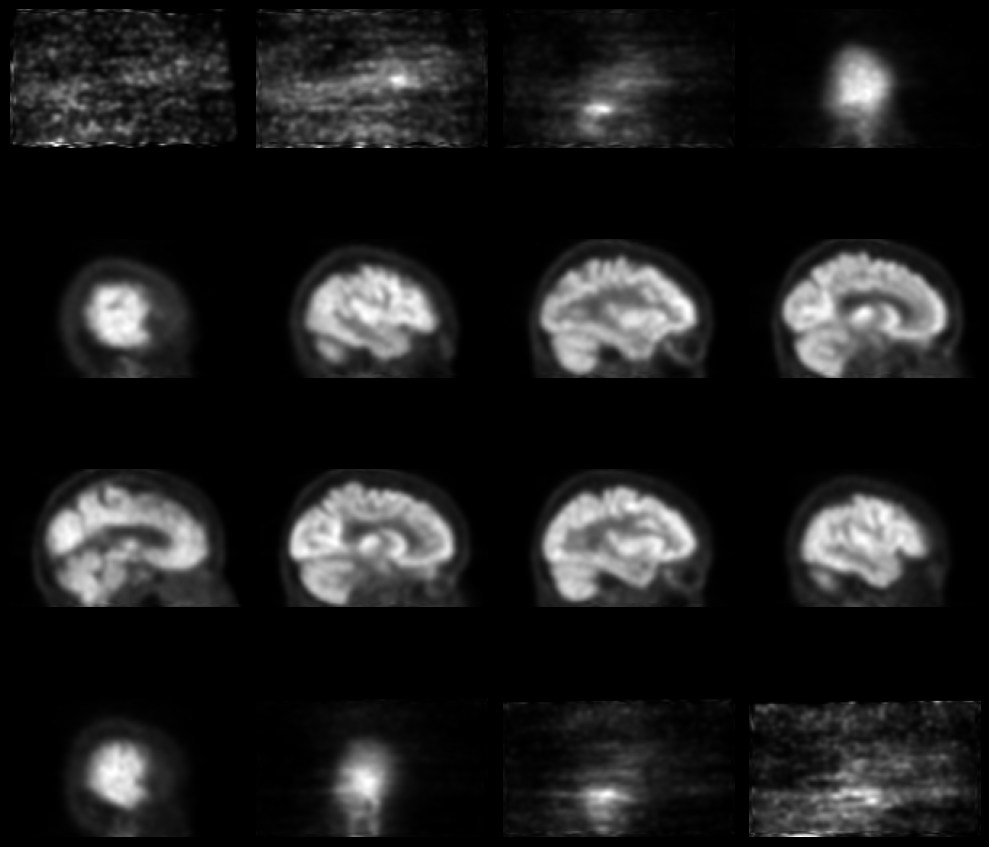

In [9]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[0]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[img, :, :], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

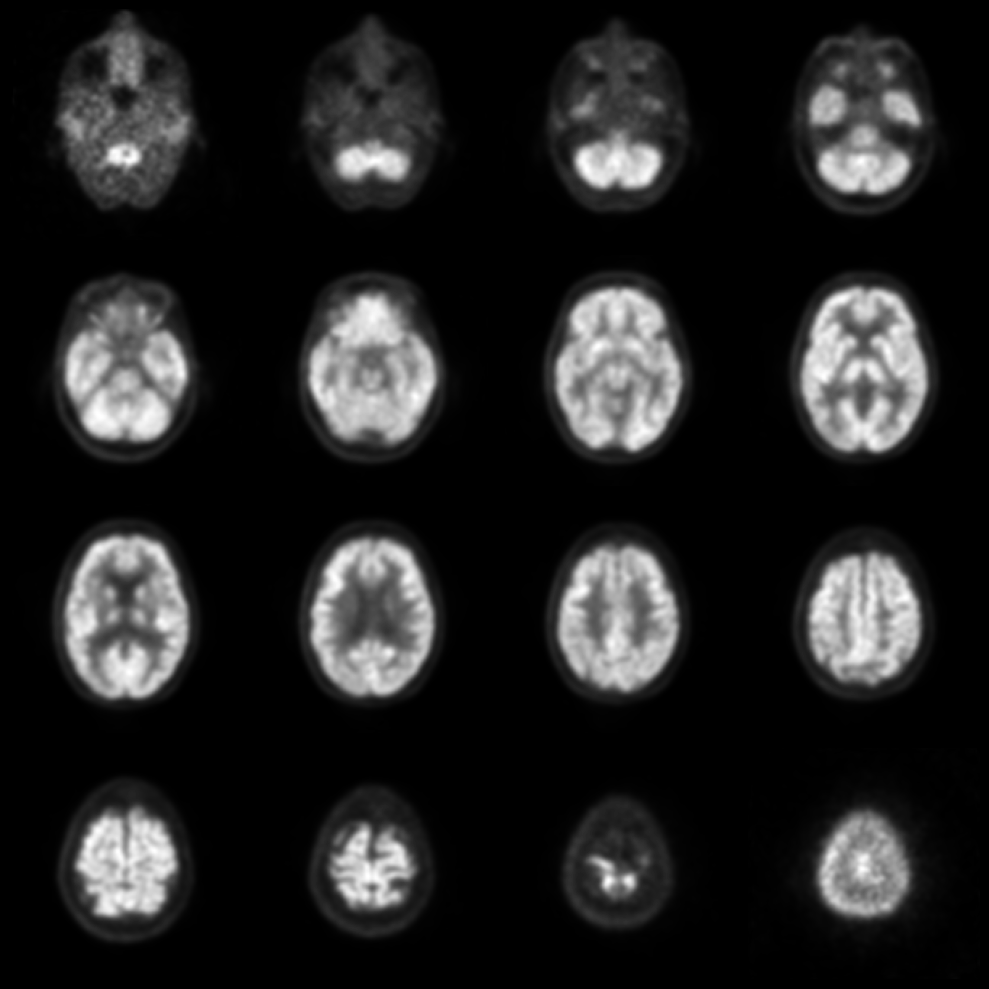

In [10]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

Ahora quiero eliminar la mitad de los slices, un cuarto arriba y un cuarto abajo

(160, 160, 96, 1)
n_slice: 48
n_slice_padding: 24


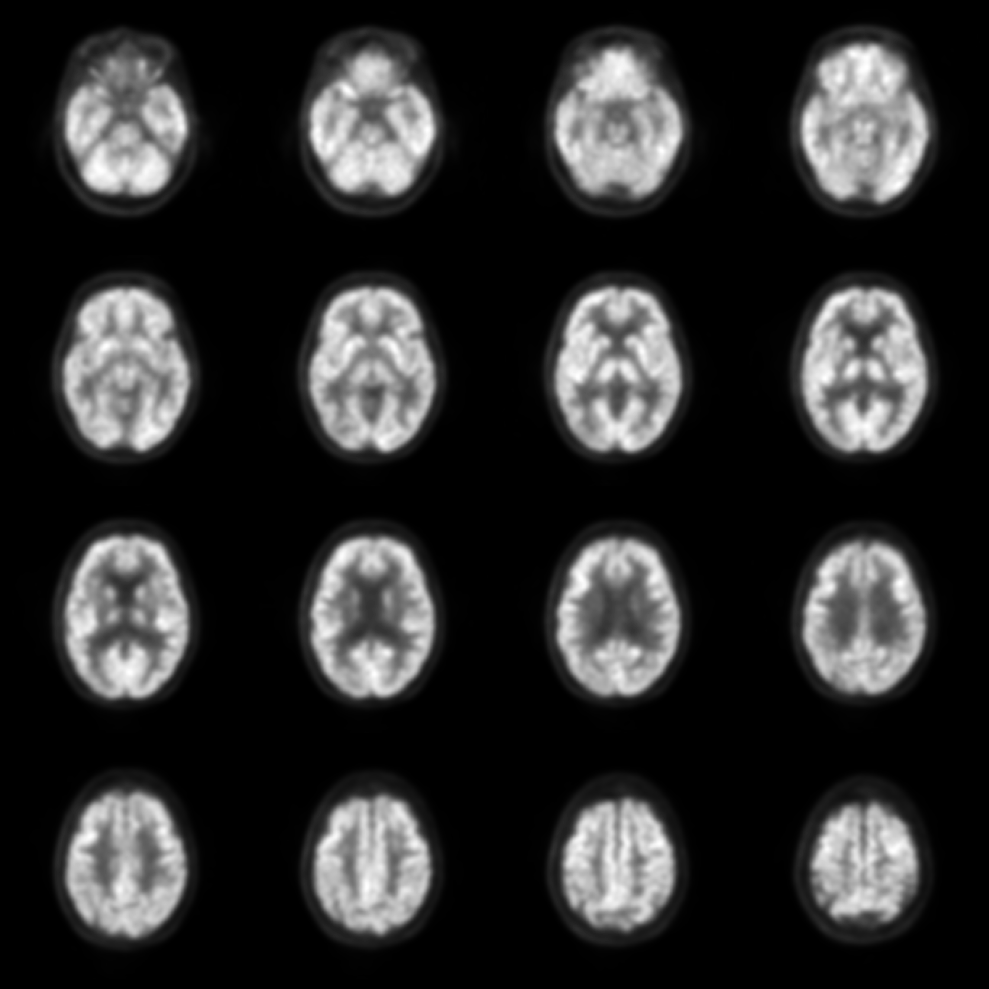

In [11]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
slices_to_eliminate = 48

print(brain_vol_data.shape)

n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos 16 slices
n_slice = n_slice - slices_to_eliminate

print("n_slice: " + str(n_slice))
print("n_slice_padding: " + str(n_slice_padding))

step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int(n_slice_padding + (n_slice - plot_range) / 2)

slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')

idx = 0
for img in slice_indices:
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
    idx += 1
        
plt.tight_layout()
plt.show()

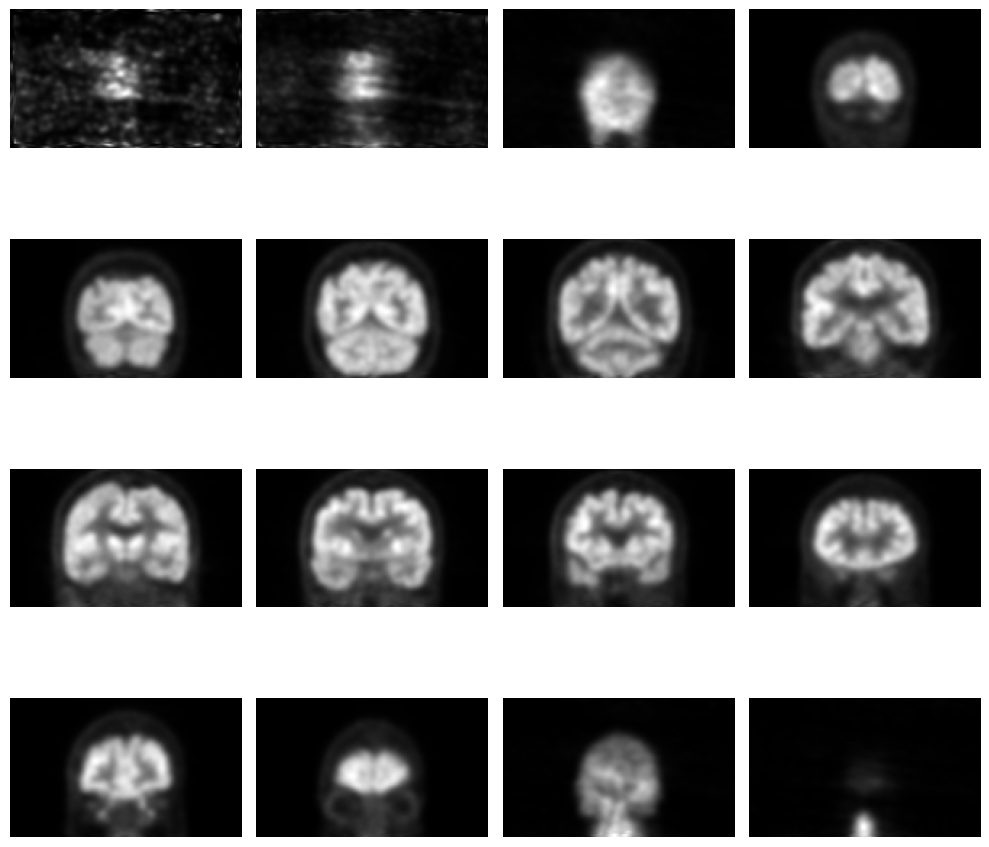

In [12]:
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[1]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, img, :], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

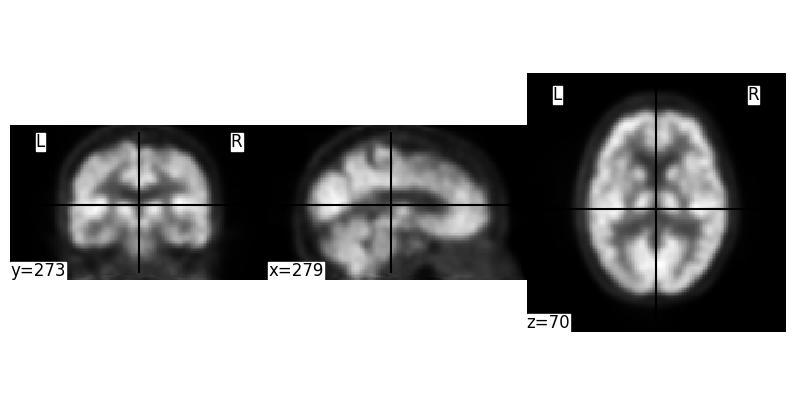

In [13]:
from nilearn import plotting

fig, ax = plt.subplots(figsize=[10, 5])
plotting.plot_img(brain_vol, cmap='gray', axes=ax)
plt.show()

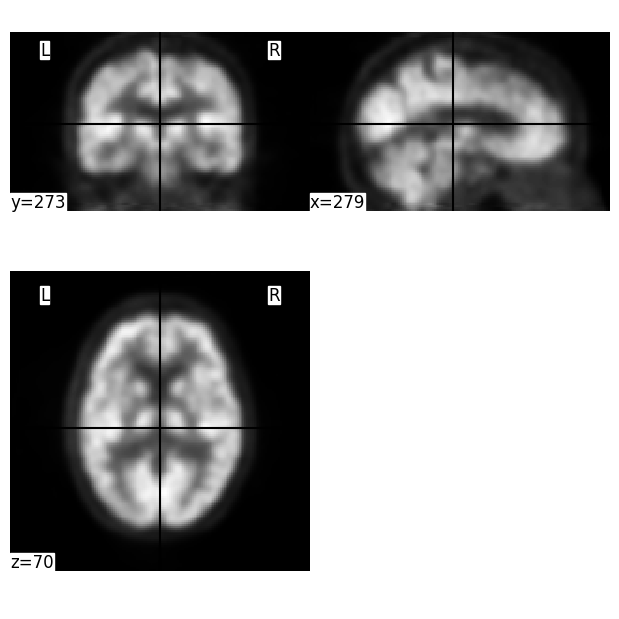

In [14]:
plotting.plot_img(brain_vol, display_mode='tiled', cmap='gray')
plt.show()

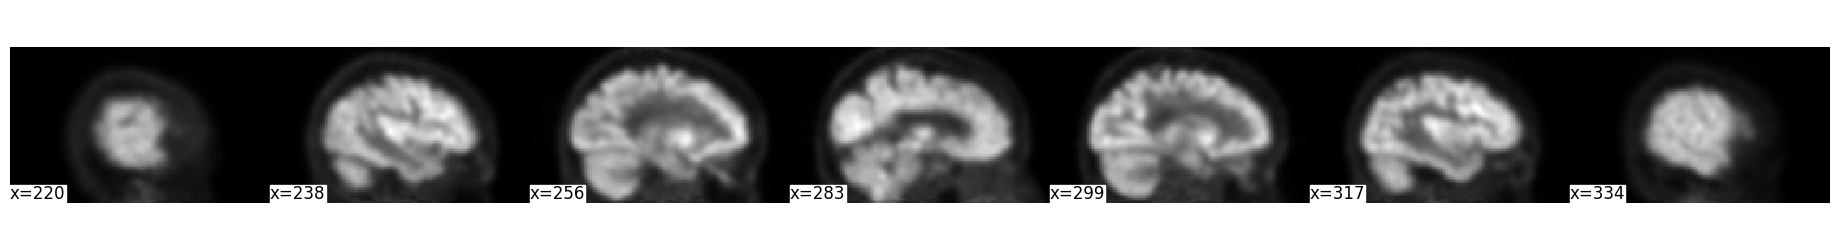

In [15]:
plotting.plot_img(brain_vol, display_mode='x', cmap='gray')
plt.show()

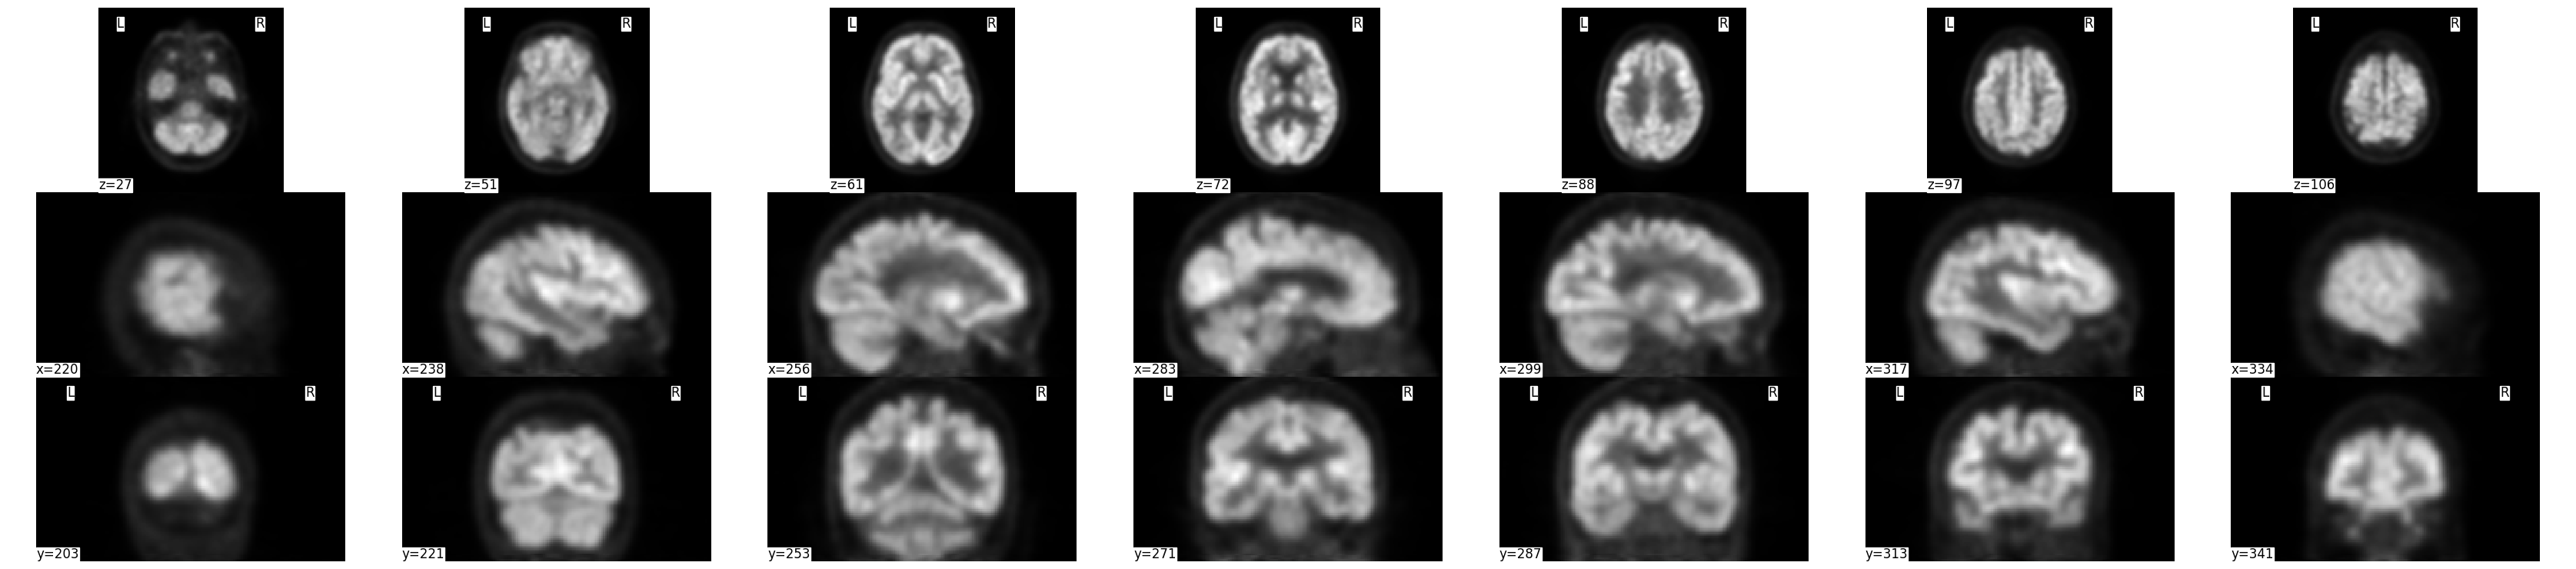

In [16]:
plotting.plot_img(brain_vol, display_mode='mosaic', cmap='gray')
plt.show()

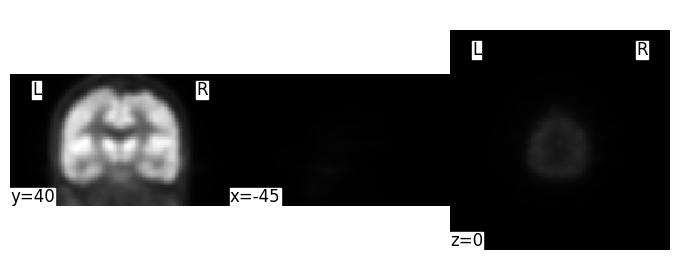

In [17]:
from nilearn import image

fwhm = 4

brain_vol_smth = image.smooth_img(brain_vol, fwhm)
plotting.plot_img(brain_vol_smth, cmap='gray', cut_coords=(-45, 40, 0))
plt.show()

# 6mm

In [18]:
brain_vol = nib.load('ADNI-Full-PostProc/ADNI-10/003_S_1057/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res/2008-03-14_11_34_32.0/I1593493/ADNI_003_S_1057_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res_Br_20220622121326826_73_S47459_I1593493.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'003_S_1057'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 160 160  96   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.  1.5 1.5 1.5 0.  0.  0.  0. ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 160.0
qoffset_y       : 160.0
qoffset_z       : 1.5
srow_x          : [0. 0. 0. 

# Data Fleni, ejemplo 566

In [19]:
brain_vol = nib.load('fleniej576/13_3d_ac_cerebro_dian.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    3.27  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.0
qoffset_y       : -127.0
qoffset_z       : -49.92
srow_x          : [ -2.

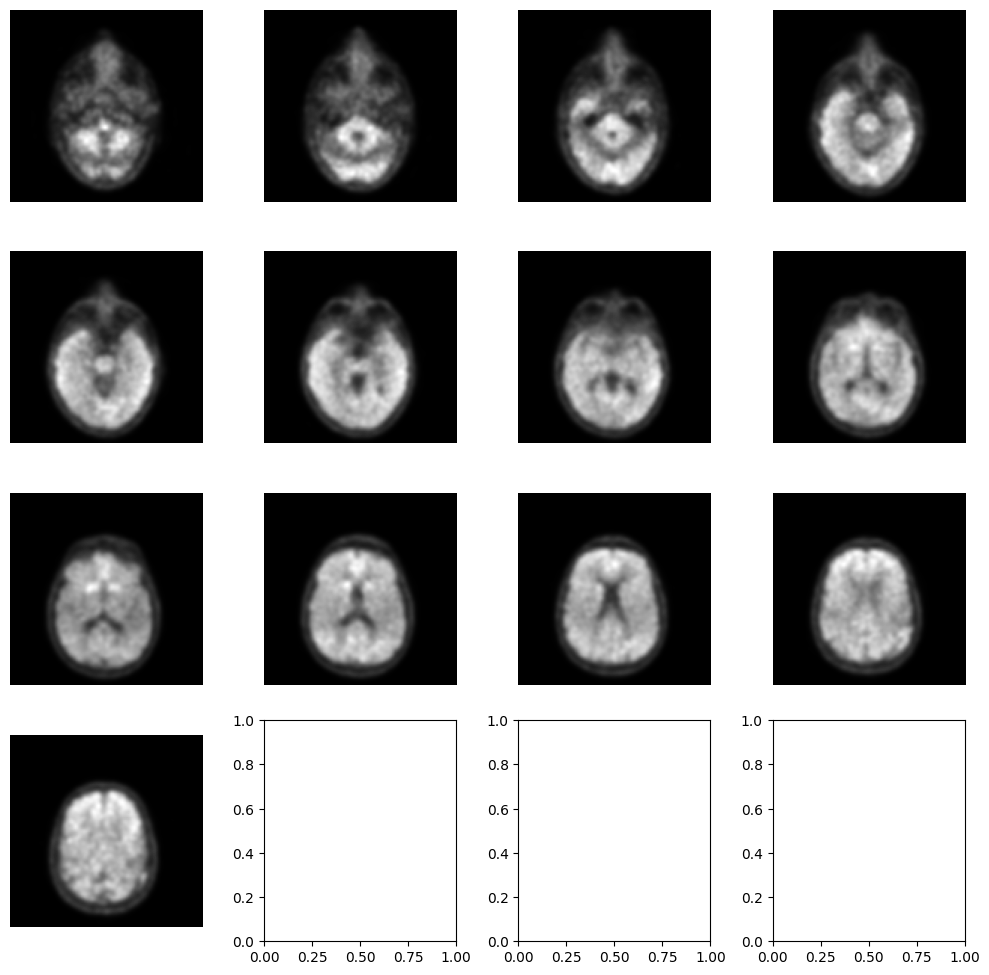

In [20]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

In [21]:
brain_vol = nib.load('fleniej576/14_3d_nac_cerebro_dian.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 192 192  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.3333334  1.3333334  3.27       1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.333336
qoffset_y       : -127.333336
qoffs

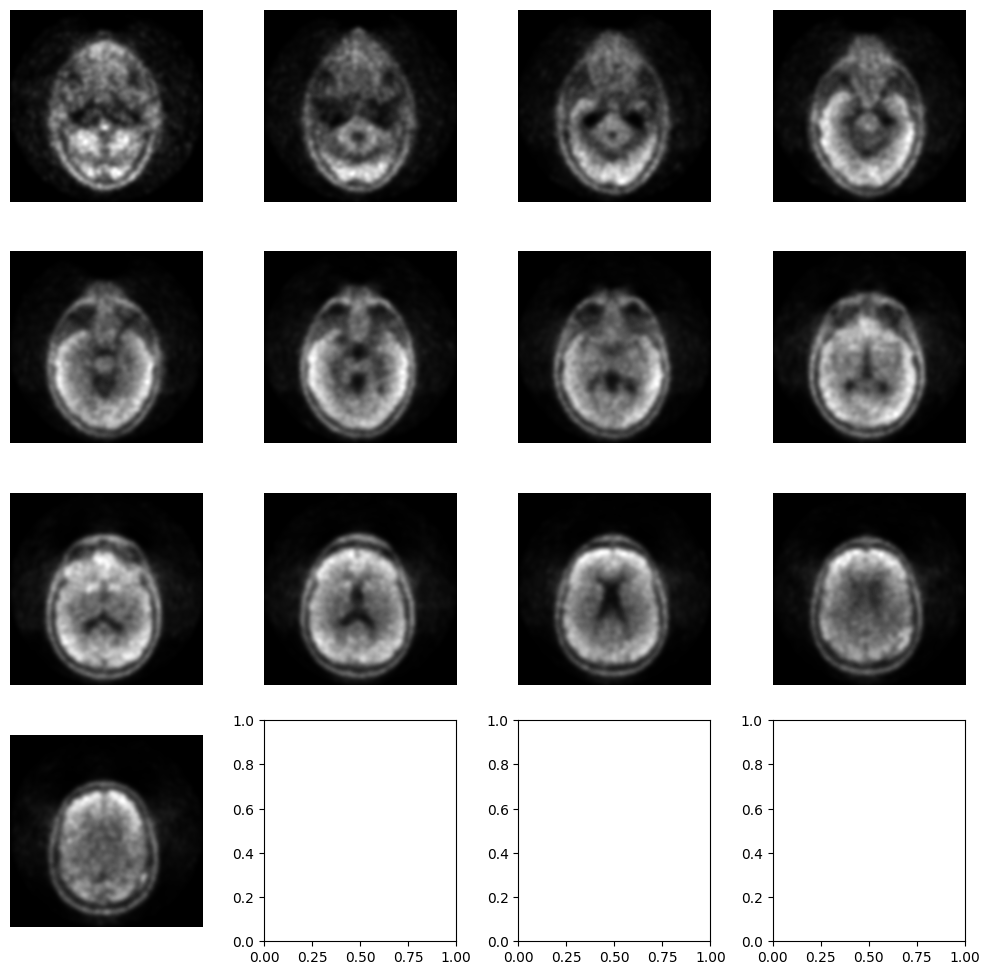

In [22]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

In [23]:
brain_vol = nib.load('fleniej576/6_3d_ac_cerebro_dian.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    3.27  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.0
qoffset_y       : -127.0
qoffset_z       : -49.92
srow_x          : [ -2.

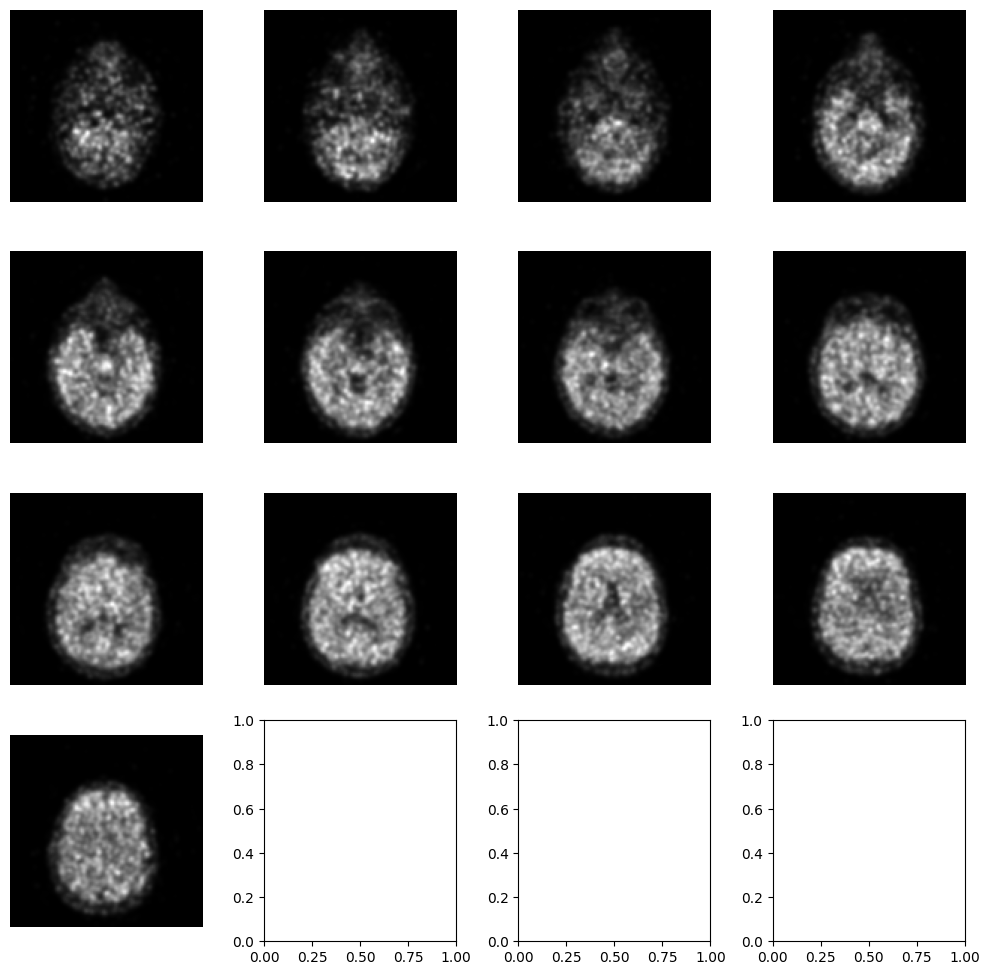

In [24]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

# Ejemplo 866

In [25]:
brain_vol = nib.load('fleniej866/6_3d_ac_cerebro_dian.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    3.27  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.0
qoffset_y       : -127.0
qoffset_z       : -25.419998
srow_x          : [

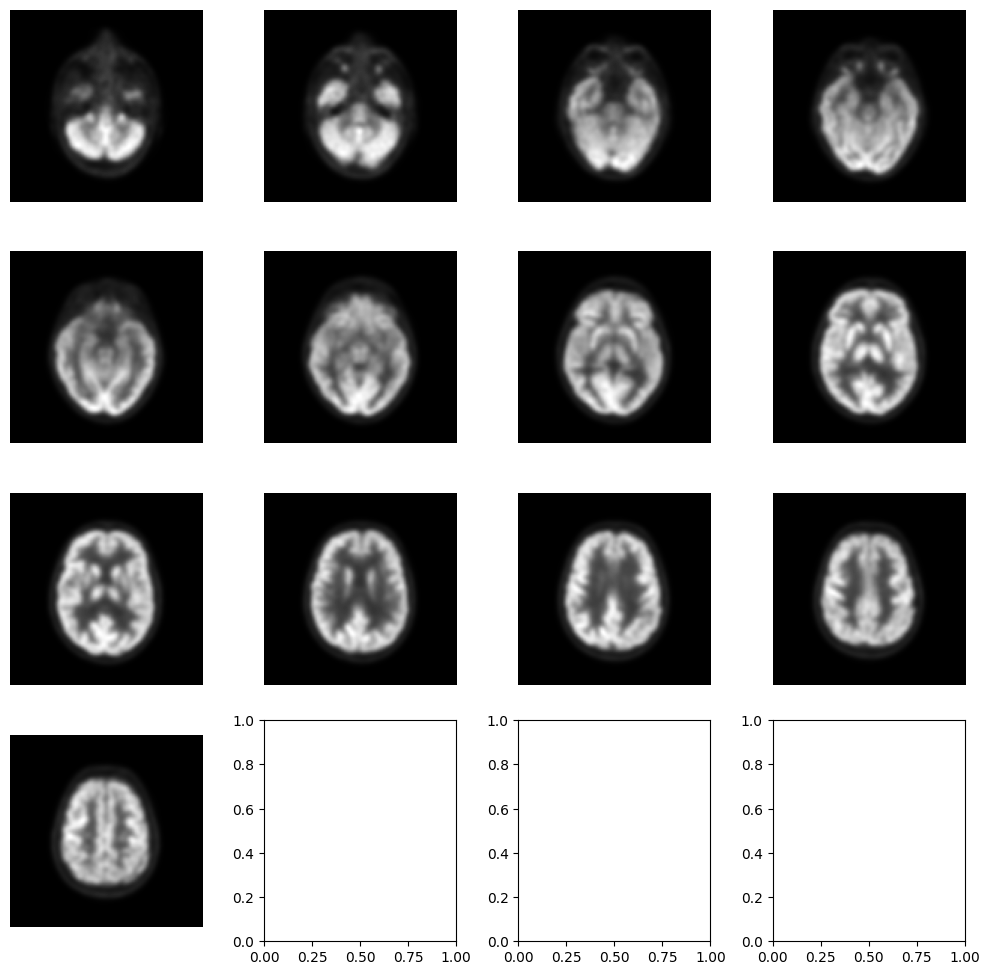

In [26]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

In [27]:
brain_vol = nib.load('fleniej866/7_3d_nac_cerebro_dian.nii')
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 192 192  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         1.3333334  1.3333334  3.27       1.         1.
  1.         1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.333336
qoffset_y       : -127.333336
qoffs

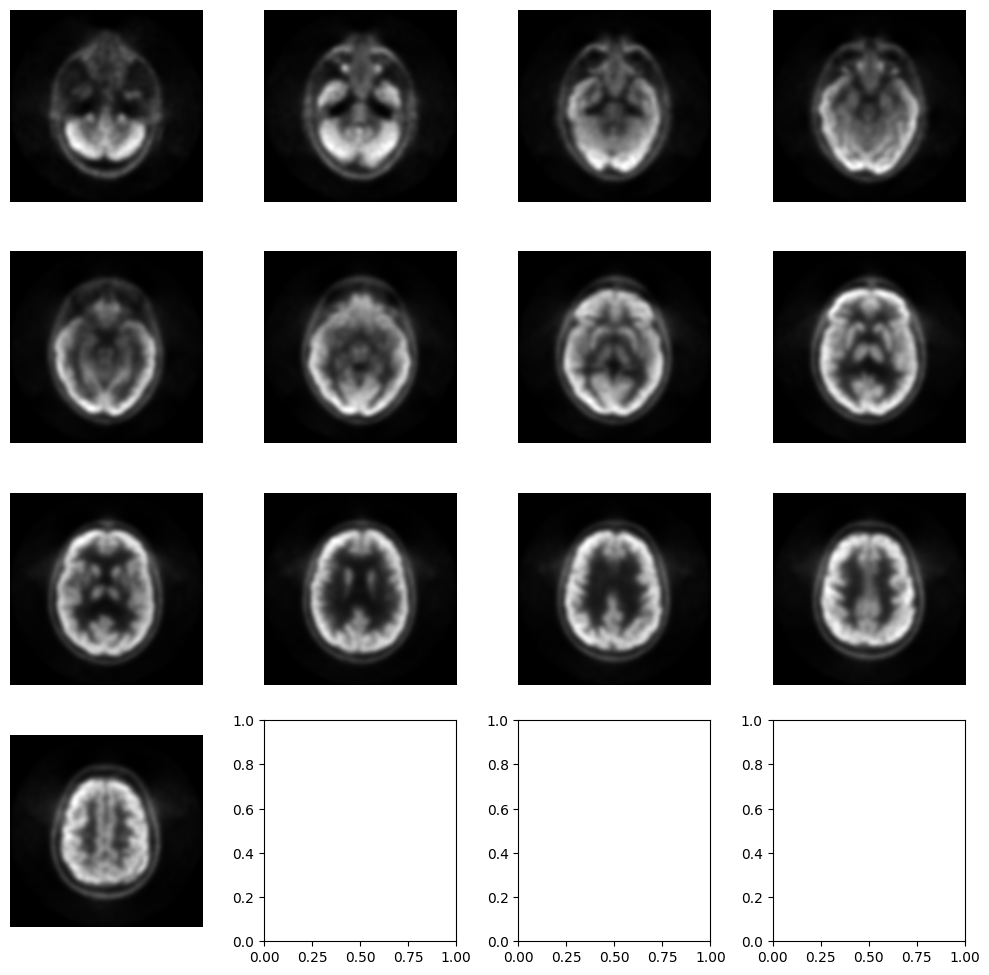

In [28]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

# Chinese DB

In [1]:
brain_vol = nib.load('Chinese/Normalized-images/mnP00000036_SUV.nii')
type(brain_vol)

NameError: name 'nib' is not defined

In [30]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 2
glmin           : 0
descrip         : b''
aux_file        : b'none'
qform_code      : unknown
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [  2.   0.   0. -90.]
srow_y    

# EBRAINS

In [44]:
brain_vol = nib.load('ebrains/data/hc images/sws0042855A-207260-00001-000001.hdr')
type(brain_vol)

nibabel.nifti1.Nifti1Pair

In [45]:
print(brain_vol)

<class 'nibabel.nifti1.Nifti1Pair'>
data shape (79, 95, 68)
affine: 
[[  -2.    0.    0.   78.]
 [   0.    2.    0. -112.]
 [   0.    0.    2.  -50.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1PairHeader'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 79 95 68  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  0.  0.  0.  0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'spm - 3D normalized - conv(14,14,14)'
aux_file        : b''
qform_code 

In [46]:
brain_vol.header['dim']

array([ 3, 79, 95, 68,  1,  1,  1,  1], dtype=int16)

Trato de convertirlo a ver si puedo llevarlo a 128x128

In [39]:
scaleX = 79/128
scaleY = 95/128
if scaleY > scaleX:
    scale = scaleY
else:
    scale = scaleX
scaleAffine = np.array([
    [scale, 0, 0, 0],
    [0, scale, 0, 0],
    [0, 0, 1, 0],
   
    [0, 0, 0, 1],
])
newAffine =  brain_vol.affine @ scaleAffine
upsampled = resample_img(brain_vol, copy = True, target_affine=newAffine, interpolation='nearest')

In [40]:
print(upsampled.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 107 128  68   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.        1.484375  1.484375  2.        1.        1.        1.
  1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 78.0
qoffset_y       : -112.0
qoffset_z       : -50.

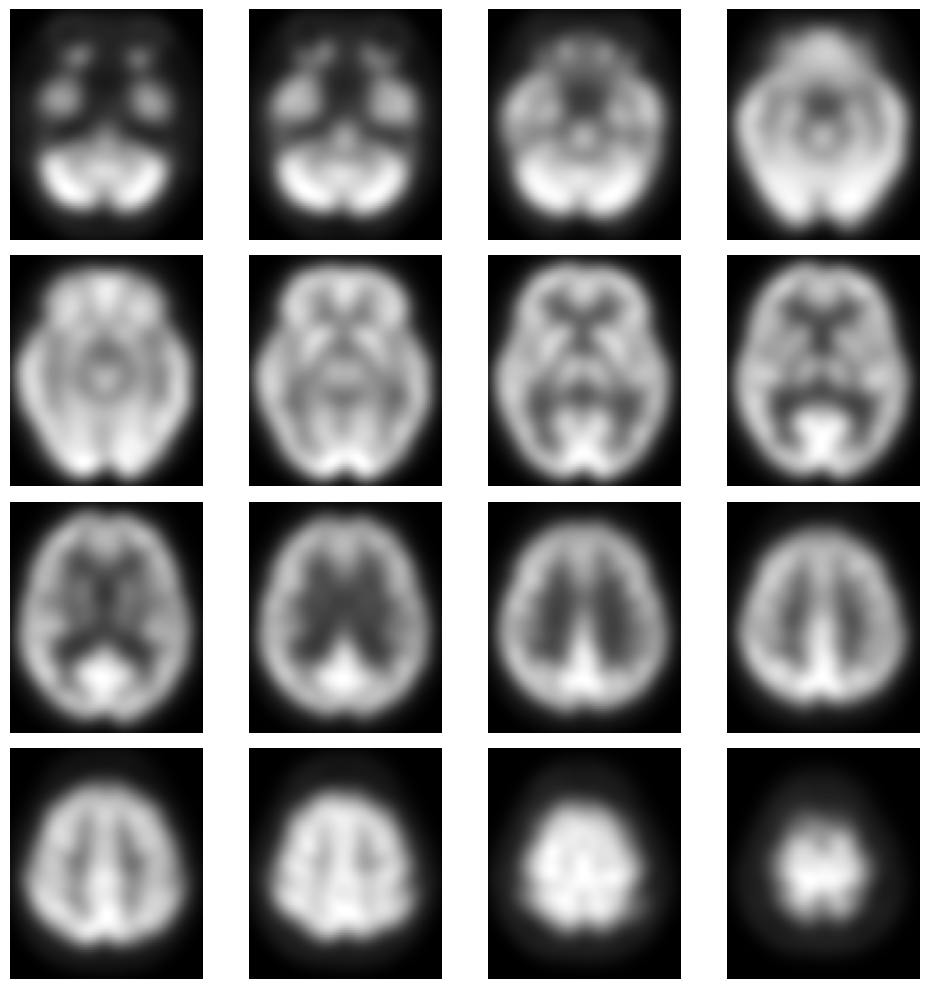

In [21]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

Fin ebrains

In [5]:
brain_vol = nib.load('ADNI 12 - raw/002_S_0729/ADNI_Brain_PET__Raw_FDG/2012-08-14_08_17_10.0/I323620/ADNI_002_S_0729_PT_ADNI_Brain_PET__Raw_FDG_br_raw_20120814110350451_328_S160717_I323620.nii')
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [6]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'002_S_0729'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 128 128  90   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 255.58594
qoffset_y       : 200.58594
qoffset_z       : 1469.5
srow_x          : [0. 0. 

In [35]:
brain_vol = nib.load('ADNI 12 - raw/002_S_4213/ADNI_Brain_PET__Raw_FDG/2013-09-09_09_01_13.0/I388951/ADNI_002_S_4213_PT_ADNI_Brain_PET__Raw_FDG_br_raw_20130909154652610_316_S200098_I388951.nii')
type(brain_vol)
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'002_S_4213'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 128 128  90   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 255.58594
qoffset_y       : 200.58594
qoffset_z       : 1448.5
srow_x          : [0. 0. 

In [36]:
brain_vol = nib.load('ADNI 12 - raw/002_S_4219/ADNI_Brain_PET__Raw_FDG/2011-11-03_08_40_40.0/I264671/ADNI_002_S_4219_PT_ADNI_Brain_PET__Raw_FDG_br_raw_20111103154751407_156_S128029_I264671.nii')
type(brain_vol)
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'002_S_4219'
extents         : 16384
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 128 128  90   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 2. 2. 2. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 255.58594
qoffset_y       : 185.58594
qoffset_z       : 1216.9
srow_x          : [0. 0. 

# Fleni nuevos

In [151]:
brain_vol = nib.load('pet_fleni_1/9d88a1ea99134d49b7c6563f4d8408cb Anonymized170/9275000893814/PT 3D AC Cerebro fdgdem/14_3d_ac_cerebro_fdg-dem.nii')
type(brain_vol)
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.    2.    2.    3.27  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 127.0
qoffset_y       : -127.0
qoffset_z       : -15.919998
srow_x          : [

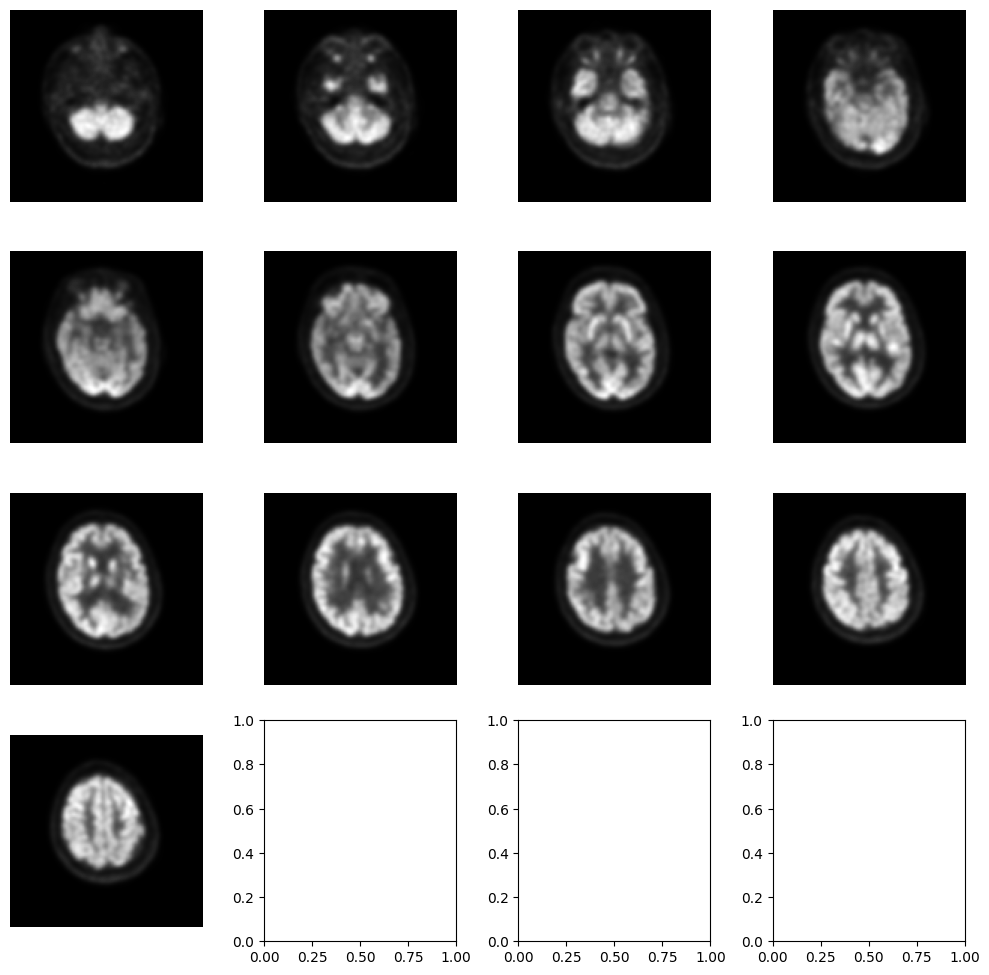

In [152]:
brain_vol_data = brain_vol.get_fdata()
fig_rows = 4
fig_cols = 4
n_subplots = fig_rows * fig_cols
n_slice = brain_vol_data.shape[2]
step_size = n_slice // n_subplots
plot_range = n_subplots * step_size
start_stop = int((n_slice - plot_range) / 2)

fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10])

for idx, img in enumerate(range(start_stop, plot_range, step_size)):
    axs.flat[idx].imshow(ndi.rotate(brain_vol_data[:, :, img], 90), cmap='gray')
    axs.flat[idx].axis('off')
        
plt.tight_layout()
plt.show()

# Comparación ADNI vs Fleni

In [14]:
slicesToCut = 0

In [11]:
def transformGridImage(sample):
    brain_vol_data = sample.get_fdata()
    fig_rows = 4
    fig_cols = 4
    n_subplots = fig_rows * fig_cols
    n_slice = brain_vol_data.shape[2]

    slices_to_eliminate = slicesToCut

    n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos n slices
    n_slice = n_slice - slices_to_eliminate

    step_size = n_slice / n_subplots

    slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')

    idx = 0
    for img in slice_indices:
        axs.flat[idx].imshow(np.squeeze(ndi.rotate(brain_vol_data[:, :, round(img)], 90)), cmap='gray')
        axs.flat[idx].axis('off')
        idx += 1
        
    plt.tight_layout()

    image = fig2img(fig)

    plt.close(fig) # Para que no muestre la imágen
    
    return image

In [12]:
# https://stackoverflow.com/questions/8598673/how-to-save-a-pylab-figure-into-in-memory-file-which-can-be-read-into-pil-image
def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    buf = io.BytesIO()
    fig.savefig(buf, facecolor='black', dpi = 64, transparent=False) # dpi Requerido para que la imagen sea 512x512
    buf.seek(0)
    img = Image.open(buf)
    return img

In [262]:
adniAD = 'ADNI-Full-PostProc/ADNI-10/002_S_5018/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-11-14_08_14_11.0/I347758/ADNI_002_S_5018_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20121126135507063_82_S174525_I347758.nii'
adniMCI = 'ADNI-Full-PostProc/ADNI-10/002_S_0729/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-08-14_08_17_10.0/I324214/ADNI_002_S_0729_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20120816152723774_56_S160717_I324214.nii'
adniCN = 'ADNI-Full-PostProc/ADNI-10/002_S_0413/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2011-06-17_09_27_22.0/I241476/ADNI_002_S_0413_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20110623163447373_45_S111993_I241476.nii'
# Fleni elegidos al azar porque no tengo los datos
fleniAD = 'pet_fleni_1/0e498a9a9cf741bf907d589ea97d6403 Anonymized171/9275000894235/PT 3D AC Cerebro fdgdem/6_3d_ac_cerebro_fdg-dem.nii'
fleniMCI = 'pet_fleni_1/2adfcccb014045cea2d52ad67da0bb07 Anonymized162/9275000894446/PT 3D AC Cerebro fdgdem/6_3d_ac_cerebro_fdg-dem.nii'
fleniCN = 'pet_fleni_1/3322d630cde4482c98056c25c8b8394c Anonymized178/9275000896322/PT 3D AC Cerebro fdgdem/6_3d_ac_cerebro_fdg-dem.nii'

# CN

Text(0.5, 1.0, 'Fleni Anonymized178')

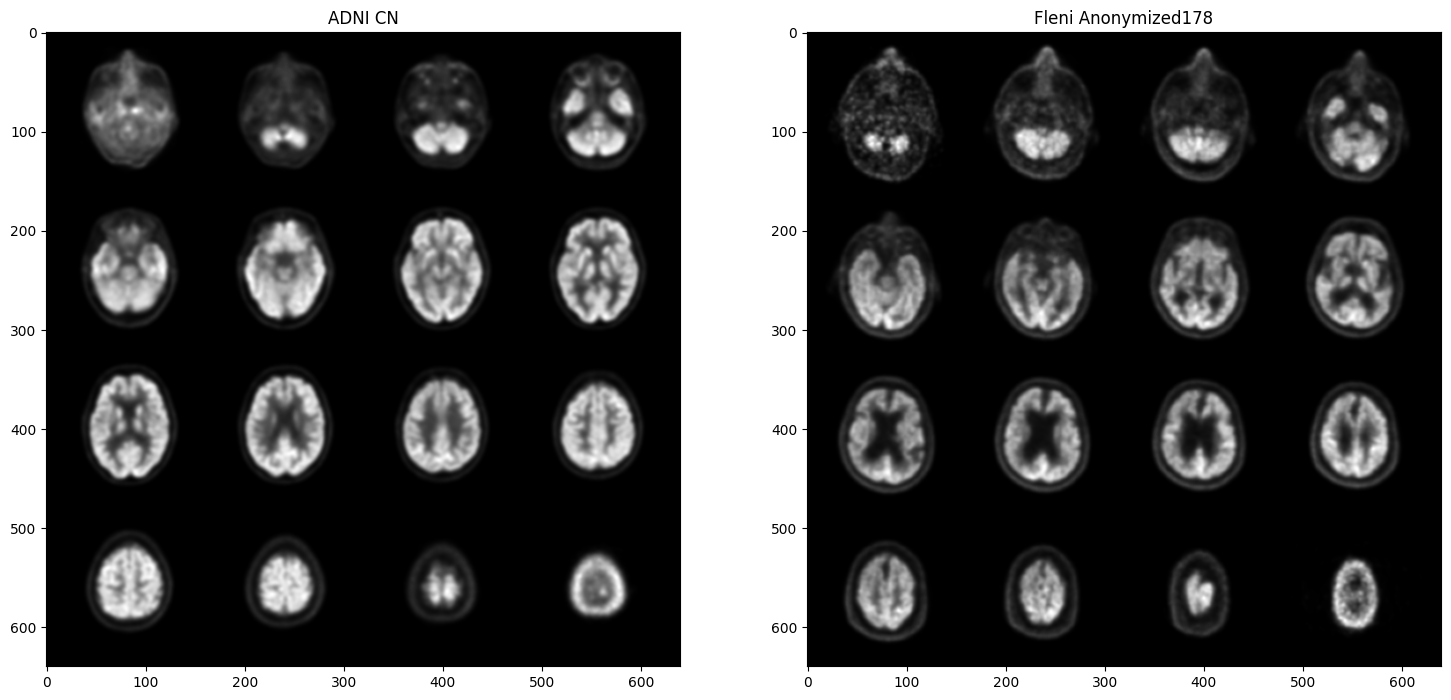

In [263]:
img = transformGridImage(nib.load(adniCN))
img2 = transformGridImage(nib.load(fleniCN))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))
ax1.imshow(img)
ax1.set_title('ADNI CN')
ax2.imshow(img2)
ax2.set_title('Fleni Anonymized178')

Con mas detalle:

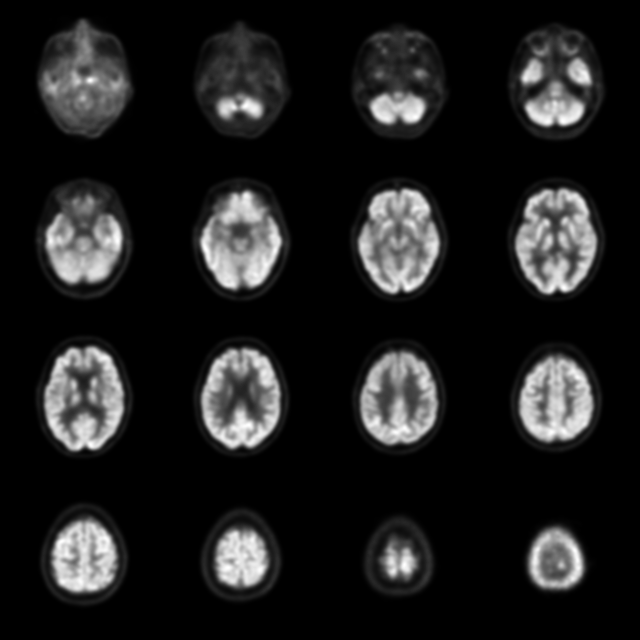

In [264]:
img = transformGridImage(nib.load(adniCN))
img

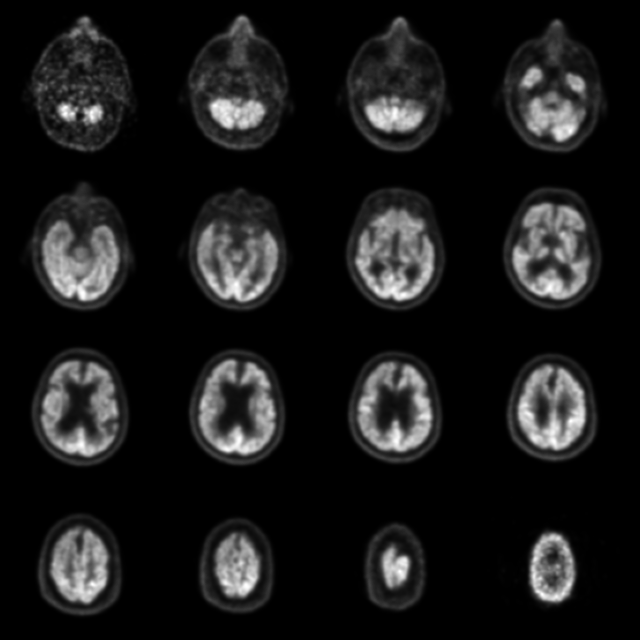

In [265]:
img2 = transformGridImage(nib.load(fleniCN))
img2

# AD

Text(0.5, 1.0, 'Fleni Anonymized171')

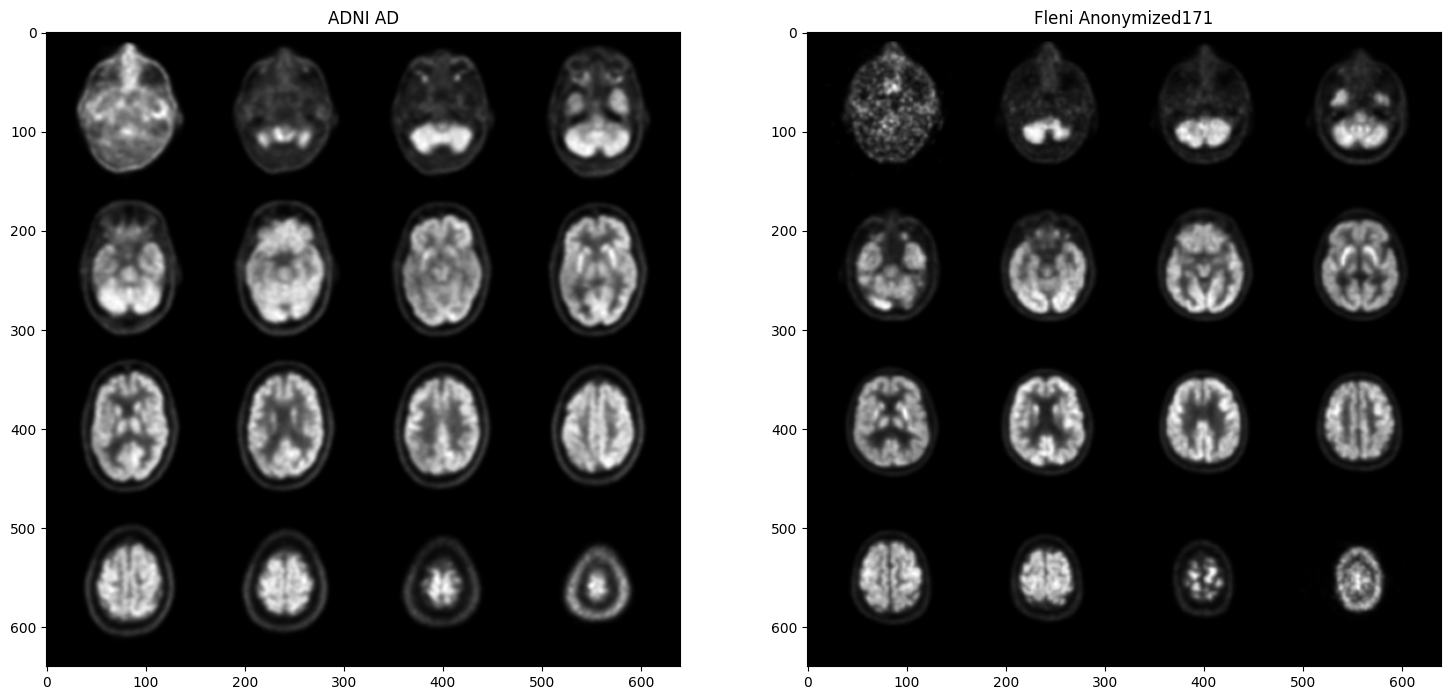

In [266]:
img = transformGridImage(nib.load(adniAD))
img2 = transformGridImage(nib.load(fleniAD))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))
ax1.imshow(img)
ax1.set_title('ADNI AD')
ax2.imshow(img2)
ax2.set_title('Fleni Anonymized171')

# MCI

Text(0.5, 1.0, 'Fleni Anonymized162')

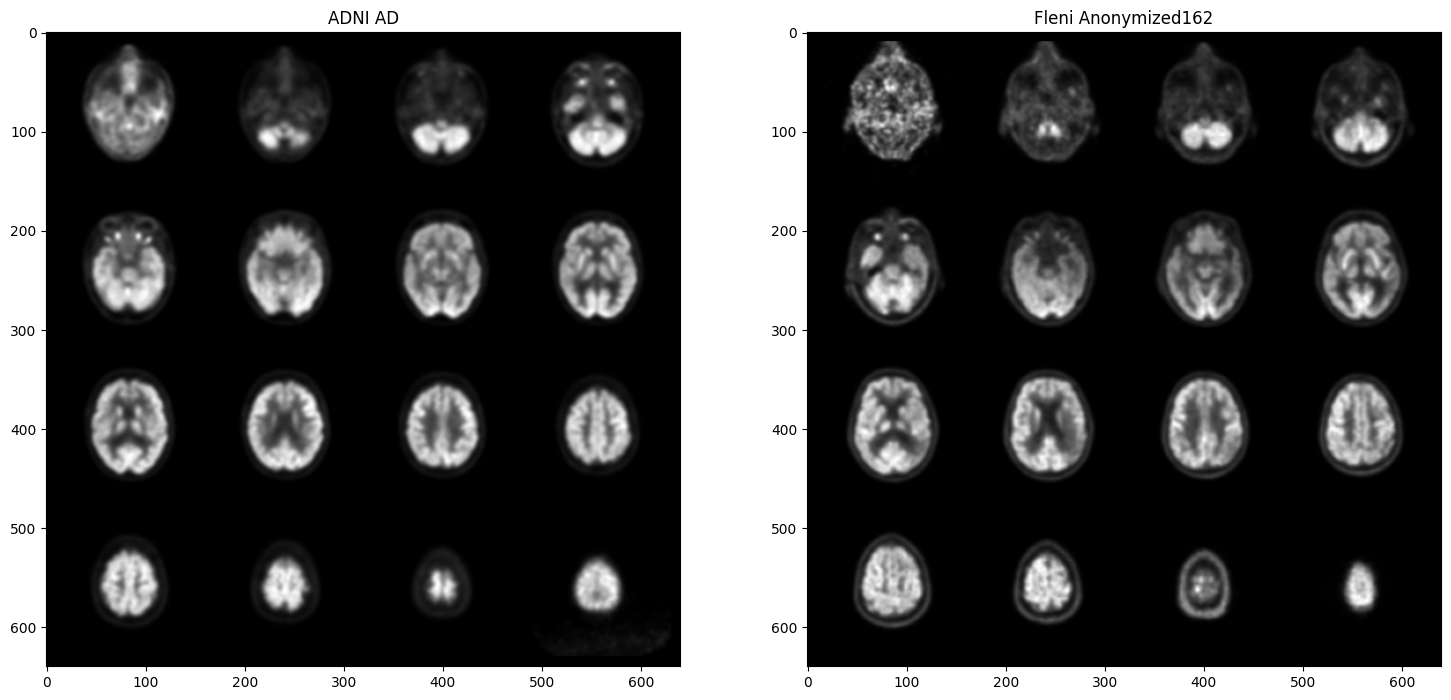

In [267]:
img = transformGridImage(nib.load(adniMCI))
img2 = transformGridImage(nib.load(fleniMCI))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))
ax1.imshow(img)
ax1.set_title('ADNI AD')
ax2.imshow(img2)
ax2.set_title('Fleni Anonymized162')

# Oasis

In [3]:
brain_vol = nib.load('./oasis3/OAS30001/OAS30001_FDG_d2650/pet1/NIFTI/sub-OAS30001_ses-d2650_acq-FDG_pet.nii.gz')
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [4]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 128 128  63  52   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [-1.         2.0033126  2.0033126  2.4250002 64.70588    0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'removed'
aux_file        : b'${NEW_FILENAME_BASE}'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 126.208694
qoffs

In [22]:
slice_data = brain_vol.get_fdata()[:, :, 15, 51].copy()
#slice_data[slice_data <= 6000] = 0

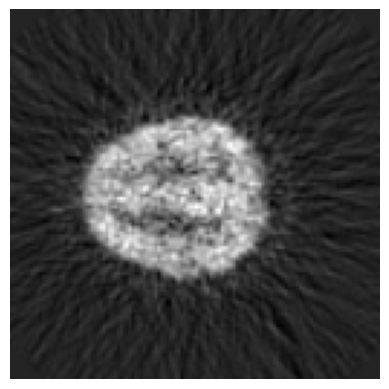

In [23]:
plt.imshow(slice_data, cmap='gray')
plt.axis('off')
plt.show()

In [45]:
data = brain_vol.get_fdata()
print(data.shape)
new_data = data[:, :, :, 51]
print(new_data.shape)

from scipy.ndimage import gaussian_filter
sigma = 2.0  # Standard deviation of the Gaussian kernel
new_data = gaussian_filter(new_data, sigma)

(128, 128, 63, 52)
(128, 128, 63)


In [46]:
new_affine = brain_vol.affine.copy()
#new_affine[0:3, 3] = 0
#new_affine

In [47]:
final_img = nib.Nifti1Image(new_data, new_affine)

In [48]:
image = transformGridImage(final_img)

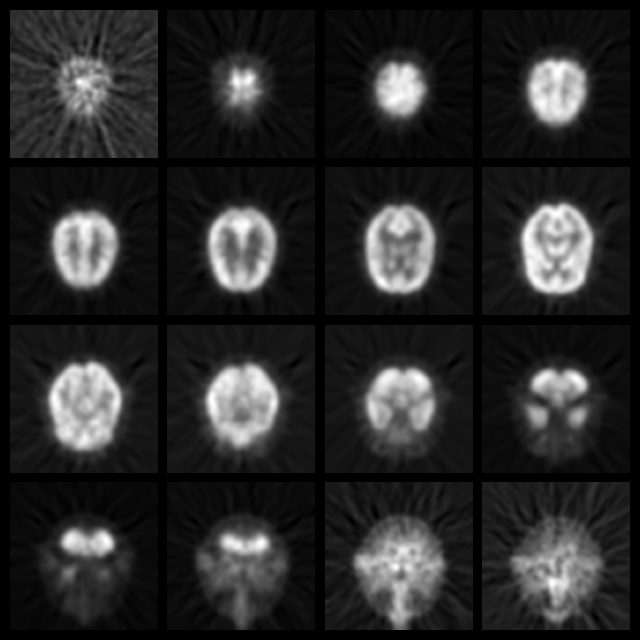

In [49]:
image

# CERMEP-IDB-MRXFDG

In [101]:
brain_vol = nib.load('/Users/hugom/PET-IA/Full-DBs/ines-merida-db/pool/DM/TEP/CERMEP_MXFDG/BASE/DATABASE_SENT/ALL/sub-0001/pet/sub-0001_pet.nii.gz')
type(brain_vol)

nibabel.nifti1.Nifti1Image

In [103]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 200 200 109   1   0   0   0]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.        2.03642   2.03642   2.027008  0.        0.        0.
  0.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'TE=0;Time=140726.000'
aux_file        : b'AC_CT_Brain_Volume_Scal'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 1.0
quatern_d       : 0.0
qoffset_x       : 204.701
q

# Rango imagenes

## Chinese

Maximo: 2.5051627159118652
Mínimo: 0.0


Text(0.5, 1.0, 'Chinese Values')

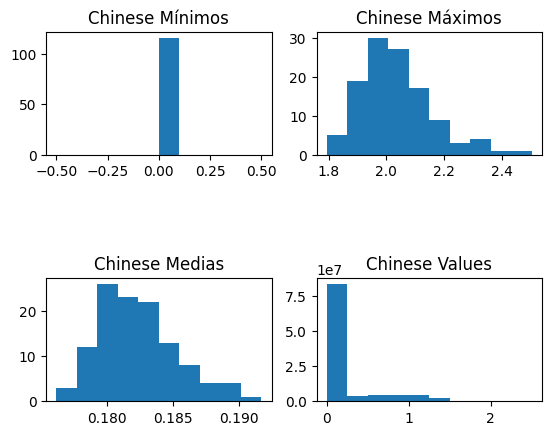

In [268]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
for path in Path('Chinese').rglob('*.nii'):
    filename = str(path)
    # print(filename)
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    # print(values)
    # print(sitk.GetArrayFromImage(img).flatten())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Chinese Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Chinese Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Chinese Medias")

ax4.hist(values, bins=10)
ax4.set_title("Chinese Values")

## EBRAINS

Maximo: 55964.18359375
Mínimo: 0.0


Text(0.5, 1.0, 'EBRAINS Values')

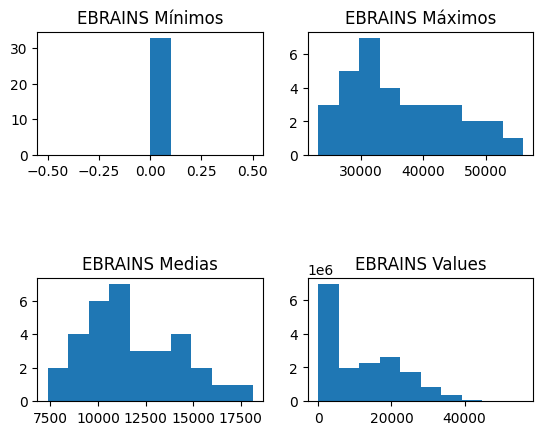

In [269]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
for path in Path('ebrains/data/hc images').rglob('*.img'):
    filename = str(path)
    # print(filename)
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("EBRAINS Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("EBRAINS Máximos")

ax3.hist(means, bins=10)
ax3.set_title("EBRAINS Medias")

ax4.hist(values, bins=10)
ax4.set_title("EBRAINS Values")

## ADNI

In [114]:
# Los cuento para chequear que no haya repetidos
files = []
for path in Path('ADNI-Full-PostProc').rglob('*Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform*.nii'):
    files.append(path.name)
files = np.array(files)
print("Cantidad: " + str(files.shape))
un = np.unique(files)
print("Archivos unicos: " + str(files.shape))

Cantidad: (6491,)
Archivos unicos: (6491,)


ADNI-Full-PostProc/ADNI-1/023_S_4122/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2011-10-27_14_20_01.0/I263195/ADNI_023_S_4122_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20111028153344162_44_S126841_I263195.nii
Maximo: 3.0003955364227295
Mínimo: -0.45621761679649353
Excluded: 1 0.026455026455026454%
Total: 3780
Menores a cero: 882
['ADNI-Full-PostProc/ADNI-4/029_S_6505/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2019-01-10_11_22_01.0/I1116394/ADNI_029_S_6505_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20190115072241677_7_S784807_I1116394.nii', 'ADNI-Full-PostProc/ADNI-4/007_S_0101/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2006-01-11_10_21_29.0/I25392/ADNI_007_S_0101_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20060929105024928_1_S10870_I25392.nii', 'ADNI-Full-PostProc/ADNI-4/137_S_0800/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2008-03-27_13_13_57.0/I100159/ADNI_137_S_0800_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_

Text(0.5, 1.0, 'ADNI Values (20 muestras)')

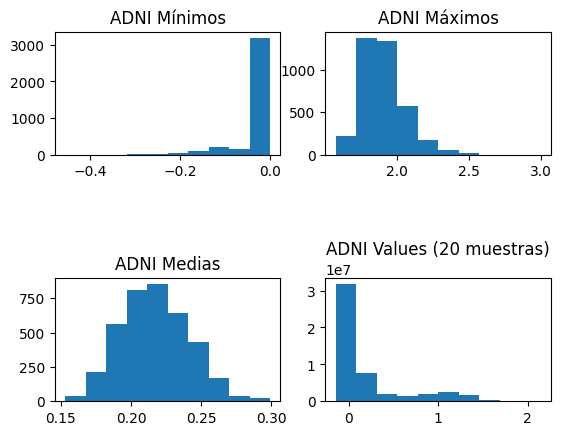

In [115]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 20
excluded = []
total = 0
menoresACero = []
for path in Path('ADNI-Full-PostProc').rglob('*Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution*.nii'):
    filename = str(path)
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
    if (stats.GetMinimum() < 0):
        menoresACero.append(filename)
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))
print("Menores a cero: " + str(len(menoresACero)))
print(menoresACero)
      

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("ADNI Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI Values (" + str(valuesConsidered) + " muestras)")

ADNI-Full-PostProc/ADNI-1/013_S_2389/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res/2013-08-09_10_22_00.0/I1594740/ADNI_013_S_2389_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res_Br_20220623144853241_22_S198056_I1594740.nii
Maximo: 5.891473770141602
Mínimo: -0.14583444595336914
Excluded: 1 0.03688675765400221%
Total: 2711


Text(0.5, 1.0, 'ADNI 6mm Values (20 muestras)')

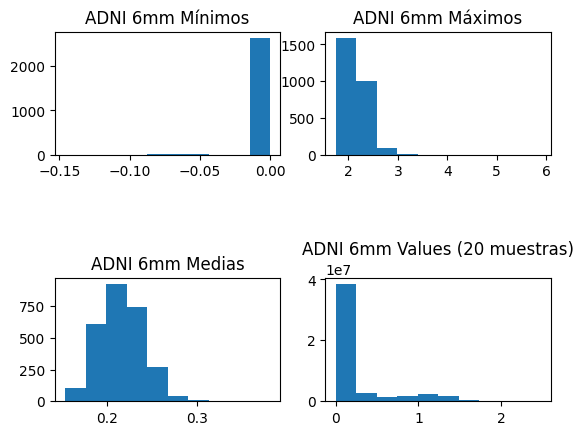

In [116]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 20
excluded = []
total = 0
for path in Path('ADNI-Full-PostProc').rglob('*Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_6mm_Res*.nii'):
    filename = str(path)
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI 6mm Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI 6mm Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI 6mm Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI 6mm Values (" + str(valuesConsidered) + " muestras)")

## Media y STD ADNI resampled preprocessed3 (valores <0 removidos)

In [10]:
import pandas as pd
# Media y std total para carpeta de pre procesadas
# TODO: estos tendrían que ser valores SOLO del set de train
values = np.empty((0), dtype=float)
#trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_dxlast_train.csv"
#trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_dxvisit_train.csv"
#trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_dxmost_severe_train.csv"
trainSet = "/Users/hugom/PET-IA/Sets/Muestra3700_80_10_10_CN,AD_dxmost_severe_train.csv"
csv = pd.read_csv(trainSet)
sum = 0.0
count = 0
for i in range(0, len(csv)):
    # Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'):
    studyID = csv.iloc[i, 1] # Image Data ID
   
    filename = os.path.join('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', studyID, 'resampled-normalized.nii')
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum += array.sum()
    count += array.shape[0]
    
    
print("Sum: " + str(sum))
print("Count: " + str(count))

Sum: 396223265.625
Count: 2320023552


In [11]:
mean = sum / count
print(mean)

0.1707841566019585


In [12]:
import math
sum2 = 0.0
for i in range(0, len(csv)):
    # Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'):
    studyID = csv.iloc[i, 1]
   
    filename = os.path.join('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3', studyID, 'resampled-normalized.nii')
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum2 += np.square(array - mean).sum()

In [13]:
std = math.sqrt(sum2 / count)
print(std)

0.39320974253448526


Maximo: 2.7909817695617676
Mínimo: 0.0
Excluded: 0 0.0%
Total: 3762


Text(0.5, 1.0, 'ADNI preprocessed3 Values (100 muestras)')

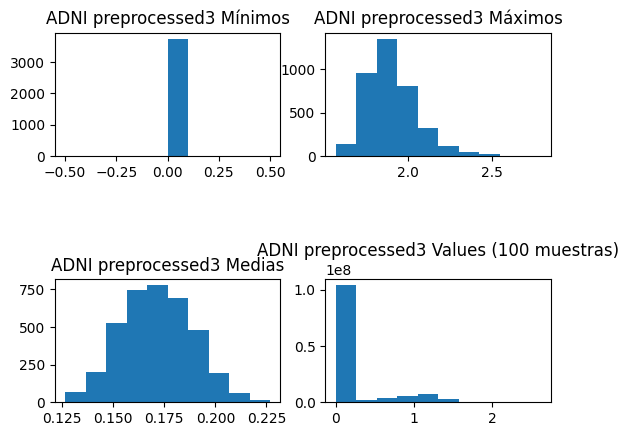

In [26]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0
paths = list(Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'))
np.random.shuffle(paths) # Mezclarlo para que las muestrass que se obtienen sean random
for path in paths:
    filename = str(path)
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI preprocessed3 Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI preprocessed3 Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI preprocessed3 Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI preprocessed3 Values (" + str(valuesConsidered) + " muestras)")

In [22]:
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import train_lib

In [23]:
# Mismo que arriba pero usando el input del modelo
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0
for path in Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'):
    filename = str(path)
    
    # TODO: a partir de acá reemplazar el código de lectura de la imágen
    # con otro código que ejecute las trasnformaciones del modelo
    # y recien hacer estadísticas con los tensores que devuelve este
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI preprocessed3 (inputTensor) Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI preprocessed3 (inputTensor) Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI preprocessed3 (inputTensor) Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI preprocessed3 (inputTensor) Values (" + str(valuesConsidered) + " muestras)")

Image (0x7fc6c02b3490)
  RTTI typeinfo:   itk::Image<float, 3u>
  Reference Count: 1
  Modified Time: 9487436
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 9487410
  UpdateMTime: 9487432
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 77]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 77]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [128, 128, 77]
  Spacing: [1.875, 1.875, 1.875]
  Origin: [-160, -160, 1.5]
  Direction: 
-1 0 0
0 -1 0
0 0 1

  IndexToPointMatrix: 
-1.875 0 0
0 -1.875 0
0 0 1.875

  PointToIndexMatrix: 
-0.533333 0 0
0 -0.533333 0
0 0 0.533333

  Inverse Direction: 
-1 0 0
0 -1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x6000024836c0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>


NameError: name 'sdf' is not defined

# Media y STD ADNI resampled preprocessed4 (sin remover los < 0)

In [41]:
import pandas as pd
# Media y std total para carpeta de pre procesadas
# TODO: estos tendrían que ser valores SOLO del set de train
values = np.empty((0), dtype=float)
trainSet = "/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL/MUESTRA3700_train.csv"
csv = pd.read_csv(trainSet)
sum = 0.0
count = 0
for i in range(0, len(csv)):
    # Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'):
    studyID = csv.iloc[i, 0]
   
    filename = os.path.join('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed4', studyID, 'resampled-normalized.nii')
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum += array.sum()
    count += array.shape[0]
    
    
print("Sum: " + str(sum))
print("Count: " + str(count))

mean = sum / count
print(mean)

import math
sum2 = 0.0
for i in range(0, len(csv)):
    # Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3').rglob('*.nii'):
    studyID = csv.iloc[i, 0]
   
    filename = os.path.join('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed4', studyID, 'resampled-normalized.nii')
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum2 += np.square(array - mean).sum()
    
std = math.sqrt(sum2 / count)
print(std)

Sum: 635812299.9575195
Count: 4144250880
0.15342032091394997
0.4048895150096513


Maximo: 2.7909817695617676
Mínimo: -0.45621761679649353
Excluded: 0 0.0%
Total: 3762


Text(0.5, 1.0, 'ADNI preprocessed4 Values (100 muestras)')

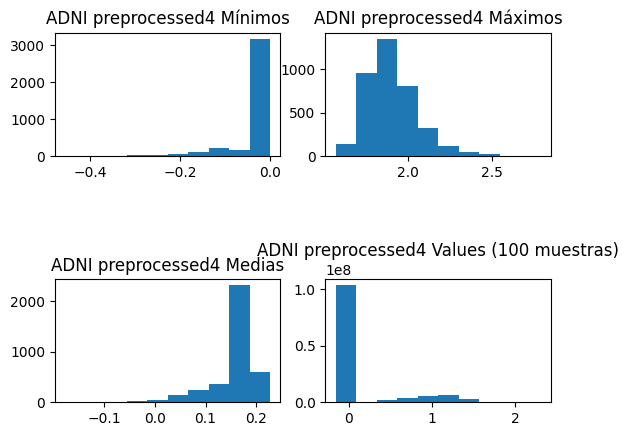

In [27]:
mins = []
maxs = []
means = []
values = np.empty((0), dtype=float)
valuesConsidered = 0 # Valores a considerar para hacer una estadistica de los valores (no medias)
maxValues = 100 # cantidad de muestras
excluded = []
total = 0
paths = list(Path('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed4').rglob('*.nii'))
np.random.shuffle(paths) # Mezclarlo para que las muestrass que se obtienen sean random
for path in paths:
    filename = str(path)
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    if (stats.GetMinimum() < -100 or stats.GetMaximum() > 100):
        print(filename)
        # print("Minimum:", stats.GetMinimum())
        # print("Maximum:", stats.GetMaximum())
        excluded.append(filename)
    else:
        mins.append(stats.GetMinimum())
        maxs.append(stats.GetMaximum())
        means.append(stats.GetMean())
        if valuesConsidered < maxValues:
            values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
            valuesConsidered+= 1
    total += 1
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))
print("Excluded: " + str(len(excluded)) + " " + str(len(excluded) * 100 / total) + "%")
print("Total: " + str(total))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)


ax1.hist(mins, bins=10)
ax1.set_title("ADNI preprocessed4 Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("ADNI preprocessed4 Máximos")

ax3.hist(means, bins=10)
ax3.set_title("ADNI preprocessed4 Medias")

ax4.hist(values, bins=10)
ax4.set_title("ADNI preprocessed4 Values (" + str(valuesConsidered) + " muestras)")

## Fleni - pet_fleni_1

Maximo: 73801.4453125
Mínimo: 0.0


Text(0.5, 1.0, 'Fleni Values')

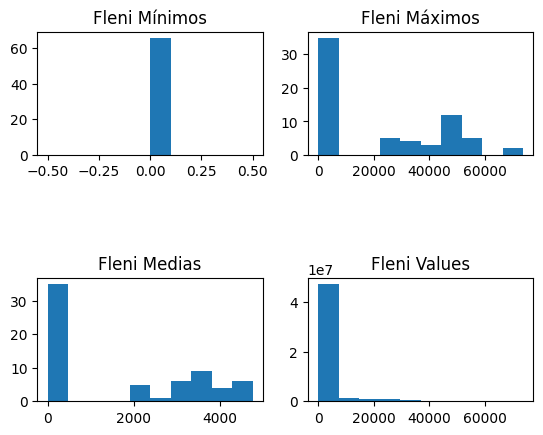

In [270]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
for path in Path('pet_fleni_1').rglob('*.nii.gz'):
    filename = str(path)
    # print(filename)
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)
    
    # MinimumMaximumImageFilter
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Fleni Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Fleni Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Fleni Medias")

ax4.hist(values, bins=10)
ax4.set_title("Fleni Values")

# Fleni - DB Myriam

Analizados: 110
Maximo: 129250.7421875
Mínimo: 0.0


Text(0.5, 1.0, 'Fleni Values')

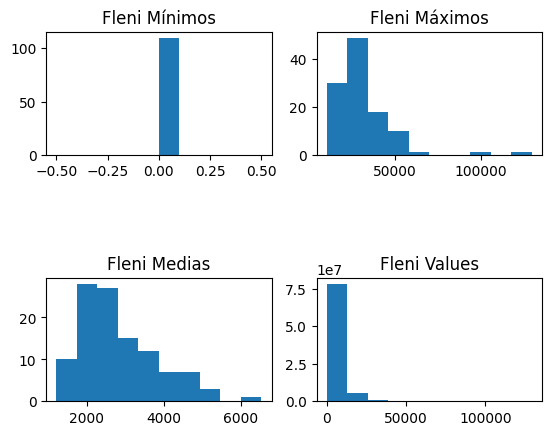

In [113]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0
for path in Path('fleni-base-myrian').rglob('*.nii.gz'):
    filename = str(path)
    # print(filename)
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)
    
    # MinimumMaximumImageFilter
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Fleni Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Fleni Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Fleni Medias")

ax4.hist(values, bins=10)
ax4.set_title("Fleni Values")

## Fleni - DB Myriam preprocessed

In [11]:
import pandas as pd
# Media y std total para carpeta de pre procesadas
sum = 0.0
count = 0
filesCount = 0
for path in Path('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3').rglob('*.nii'):
    filename = str(path)
   
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum += array.sum()
    count += array.shape[0]
    filesCount += 1
    

print("Files count: " + str(filesCount))
print("Sum: " + str(sum))
print("Count: " + str(count))

Files count: 108
Sum: 176214155584.0
Count: 83165184


In [12]:
mean = sum / count
print(mean)

2118.845256014825


In [13]:
import math
sum2 = 0.0
for path in Path('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3').rglob('*.nii'):
    filename = str(path)
    
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)

    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    
    array = sitk.GetArrayFromImage(img).flatten()
    
    sum2 += np.square(array - mean).sum()


In [14]:
std = math.sqrt(sum2 / count)
print(std)

5994.702274256329


### Histograma

Analizados: 108
Maximo: 94524.9296875
Mínimo: 0.0


Text(0.5, 1.0, 'Fleni Values')

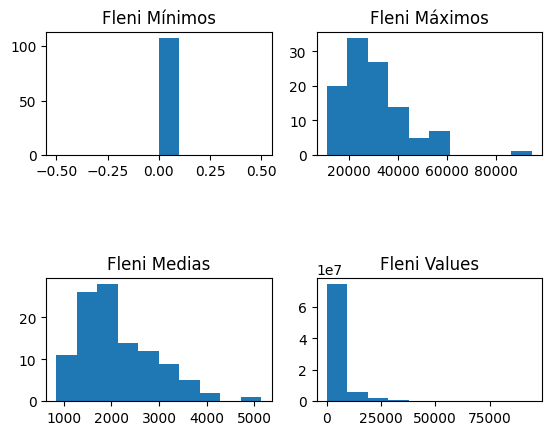

In [10]:
mins = []
maxs = []
means = []
values = []
values = np.empty((0), dtype=float)
analyzed = 0
for path in Path('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3').rglob('*.nii'):
    filename = str(path)
    # print(filename)
    reader = sitk.ImageFileReader()
    reader.SetFileName(filename)
    
    # MinimumMaximumImageFilter
    reader.LoadPrivateTagsOn()
    reader.ReadImageInformation()
    img = reader.Execute()
    stats = sitk.StatisticsImageFilter()
    stats.Execute(img)
    # print("Minimum:", stats.GetMinimum())
    # print("Maximum:", stats.GetMaximum())
    mins.append(stats.GetMinimum())
    maxs.append(stats.GetMaximum())
    means.append(stats.GetMean())
    values = np.concatenate((values, sitk.GetArrayFromImage(img).flatten()))
    analyzed += 1
print("Analizados: " + str(analyzed))
print("Maximo: " + str(max(maxs)))
print("Mínimo: " + str(min(mins)))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.subplots_adjust(hspace=1)

ax1.hist(mins, bins=10)
ax1.set_title("Fleni Mínimos")

ax2.hist(maxs, bins=10)
ax2.set_title("Fleni Máximos")

ax3.hist(means, bins=10)
ax3.set_title("Fleni Medias")

ax4.hist(values, bins=10)
ax4.set_title("Fleni Values")

# Testeo data augmentation de imágenes

## Rotación

In [272]:
brain_vol = nib.load('ADNI-Full-PostProc/ADNI-10/016_S_4902/Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution/2012-09-27_10_35_01.0/I337880/ADNI_016_S_4902_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20121003095425916_82_S168893_I337880.nii')

In [9]:
def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = ndi.zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = ndi.zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [10]:
def transformGridImage2(sample, angle = None, zoom = None, shiftX = None, shiftY = None, 
                        angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1):
    brain_vol_data = sample.get_fdata()
    fig_rows = 4
    fig_cols = 4
    n_subplots = fig_rows * fig_cols
    n_slice = brain_vol_data.shape[2]

    slices_to_eliminate = slicesToCut

    n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos n slices
    n_slice = n_slice - slices_to_eliminate

    step_size = n_slice / n_subplots

    slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')
    
    if angle == None or angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
        
    if zoom != None and random.uniform(0.0, 1.0) > zoomTransformChance:
        zoom = None
        
    if shiftX != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftX = None
        
    if shiftY != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftY = None

    idx = 0
    for img in slice_indices:
        processedImage = ndi.rotate(brain_vol_data[:, :, round(img)], 90.0 + angle)
        if zoom != None:
            processedImage = clipped_zoom(processedImage, zoom)
        if shiftX != None:
            processedImage = ndi.shift(processedImage, [0.0, shiftX, 0.0])
        if shiftY != None:
            processedImage = ndi.shift(processedImage, [shiftY, 0.0, 0.0])
        axs.flat[idx].imshow(np.squeeze(processedImage), cmap='gray')
        axs.flat[idx].axis('off')
        idx += 1
        
    plt.tight_layout()

    image = fig2img(fig)

    plt.close(fig) # Para que no muestre la imágen
    
    return image

In [11]:
angle = 15
img = transformGridImage2(brain_vol, angle, angleTransformChance = 1.0, zoomTransformChance = 0.0, shiftTransformChance = 0.0)
img

NameError: name 'slicesToCut' is not defined

In [12]:
angle = -15
img = transformGridImage2(brain_vol, angle, angleTransformChance = 1.0, zoomTransformChance = 0.0, shiftTransformChance = 0.0)
img

NameError: name 'slicesToCut' is not defined

## Zoom

In [13]:
angle = None
zoom = 1.2
img = transformGridImage2(brain_vol, angle, zoom, angleTransformChance = 0.0, zoomTransformChance = 1.0, shiftTransformChance = 0.0)
img

NameError: name 'slicesToCut' is not defined

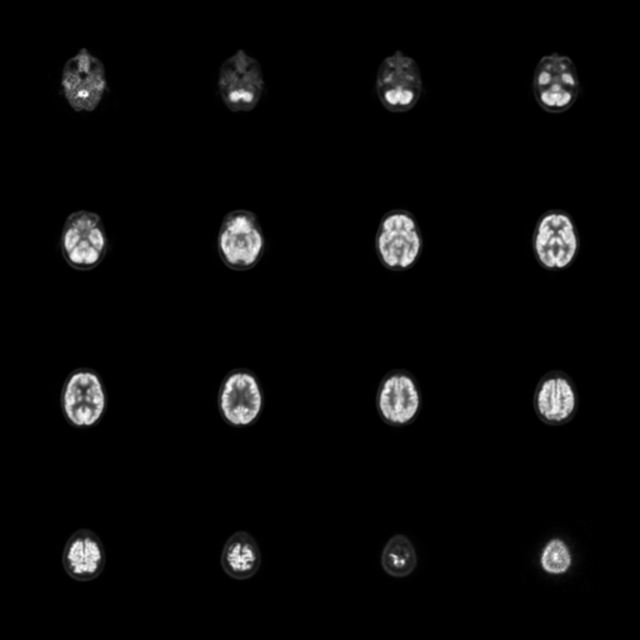

In [353]:
angle = None
zoom = 0.5
img = transformGridImage2(brain_vol, angle, zoom, angleTransformChance = 0.0, zoomTransformChance = 1.0, shiftTransformChance = 0.0)
img

## Left y top shift

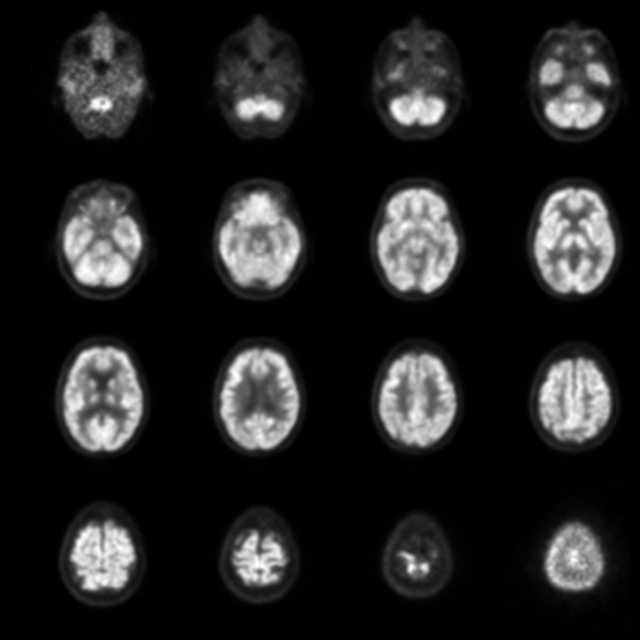

In [354]:
angle = None
zoom = None
shiftX = 20.0
img = transformGridImage2(brain_vol, angle, zoom, shiftX = shiftX, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 1.0)
img

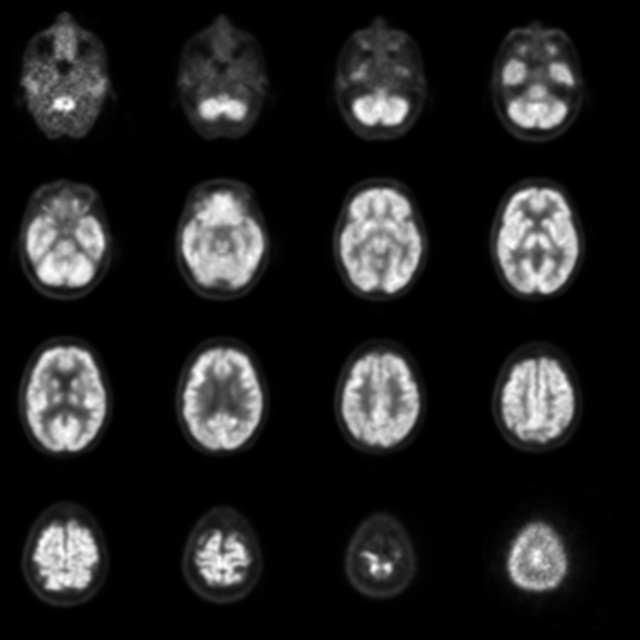

In [355]:
angle = None
zoom = None
shiftX = -20.0
img = transformGridImage2(brain_vol, angle, zoom, shiftX = shiftX, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 1.0)
img

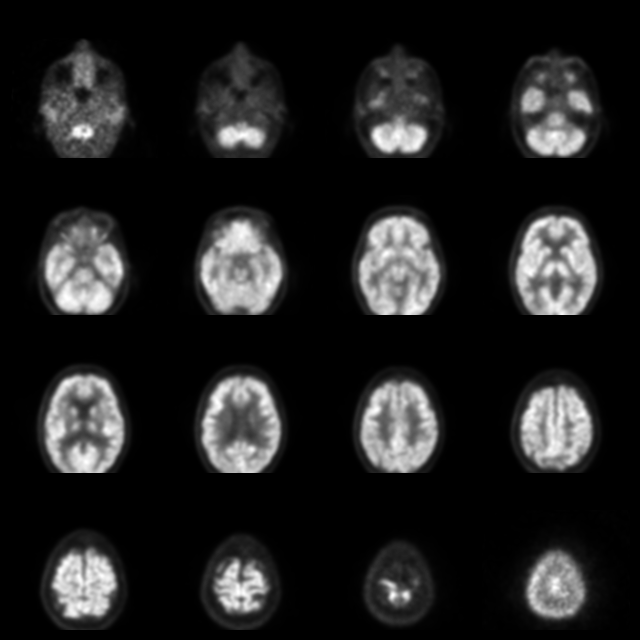

In [356]:
angle = None
zoom = None
shiftY = 30.0
img = transformGridImage2(brain_vol, angle, zoom, shiftY = shiftY, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 1.0)
img

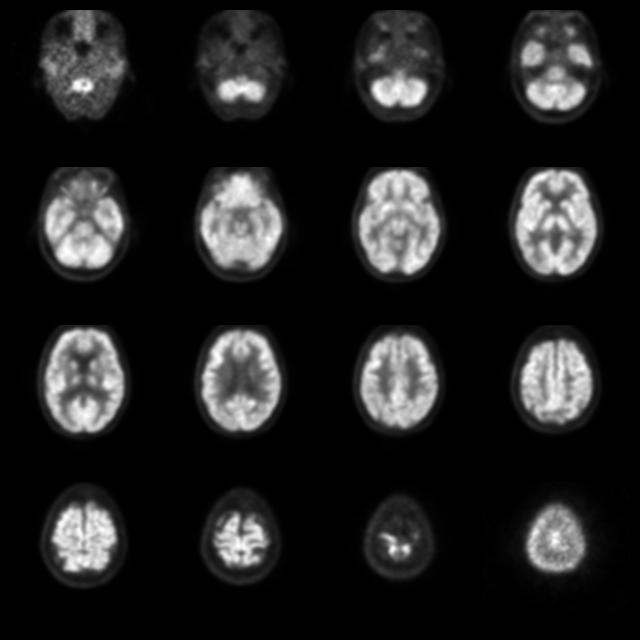

In [357]:
angle = None
zoom = None
shiftY = -20.0
img = transformGridImage2(brain_vol, angle, zoom, shiftY = shiftY, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 1.0)
img

# Random transformations

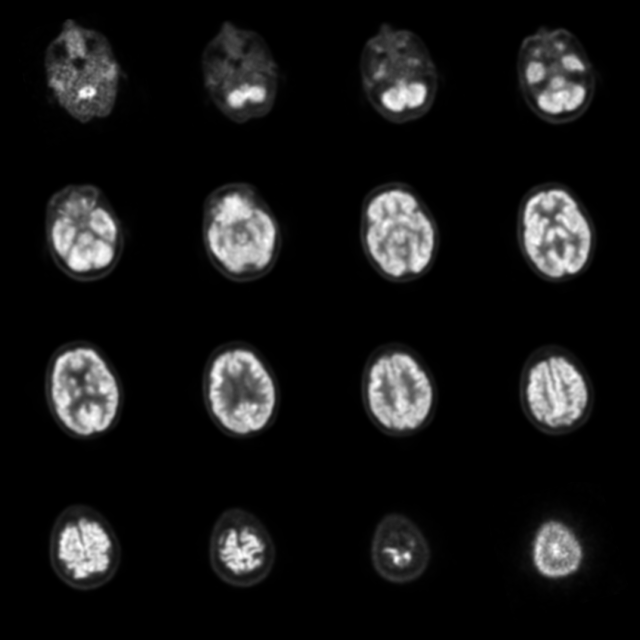

In [383]:
angle = 15.0 * random.choice([-1, 1])
zoom = 1.0 + 0.1 * random.choice([-1, 1])
shiftX = 10.0 * random.choice([-1, 1])
shiftY = 10.0 * random.choice([-1, 1])
img = transformGridImage2(brain_vol, angle, zoom, shiftX = shiftX, shiftY = shiftY, 
                          angleTransformChance = 0.5, zoomTransformChance = 0.5, shiftTransformChance = 0.5)
img

In [32]:
brain_vol = nib.load('/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped/ADNI_941_S_7041_PT_Coreg,_Avg,_Std_Img_and_Vox_Siz,_Uniform_Resolution_Br_20220316150818191_68_S1113954_I1557047.nii')

In [ ]:
print(brain_vol)

# Agregamos descarte de slices por superfície

In [72]:
def transformGridImage3(sample, angle = None, zoom = None, shiftX = None, shiftY = None, 
                        angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1, 
                        slicesToCut = 0, minSliceSurface = None, pixelSurface = 1.5, minSliceSurfaceThreshold = 0.0):
    brain_vol_data = sample.get_fdata()
    fig_rows = 4
    fig_cols = 4
    n_subplots = fig_rows * fig_cols
    
    
    # Chequeo de eliminar slices por superfície
    if minSliceSurface != None:
            withMoreThan100 = 0
            deleteIndices = []
            if minSliceSurface <= 0.0:
                    raise Exception("minSliceSurface should be > 0.0")
            for i in range(0, brain_vol_data.shape[2]):
                    surface = 0.0
                    for j in range(0, brain_vol_data.shape[0]):
                            for k in range(0, brain_vol_data.shape[1]):
                                    if brain_vol_data[j][k][i] > minSliceSurfaceThreshold:
                                            surface += pixelSurface
                    if surface >= minSliceSurface:
                            withMoreThan100 += 1
                    else:
                            deleteIndices.append(i)
            if withMoreThan100 < 16:
                    raise Exception('No enough brain surface (' + str(withMoreThan100) + ' slices)')
            brain_vol_data = np.delete(brain_vol_data, deleteIndices, axis=2)

    
    n_slice = brain_vol_data.shape[2]

    slices_to_eliminate = slicesToCut

    n_slice_padding = slices_to_eliminate // 2 # quitamos los primeros y ultimos n slices
    n_slice = n_slice - slices_to_eliminate

    step_size = n_slice / n_subplots

    slice_indices = np.arange(n_slice_padding, n_slice_padding + n_slice, step = step_size)

    fig, axs = plt.subplots(fig_rows, fig_cols, figsize=[10, 10], facecolor='black')
    
    if angle == None or angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
        
    if zoom != None and random.uniform(0.0, 1.0) > zoomTransformChance:
        zoom = None
        
    if shiftX != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftX = None
        
    if shiftY != None and random.uniform(0.0, 1.0) > shiftTransformChance:
        shiftY = None

    idx = 0
    for img in slice_indices:
        processedImage = ndi.rotate(brain_vol_data[:, :, round(img)], 90.0 + angle)
        if zoom != None:
            processedImage = clipped_zoom(processedImage, zoom)
        if shiftX != None:
            processedImage = ndi.shift(processedImage, [0.0, shiftX, 0.0])
        if shiftY != None:
            processedImage = ndi.shift(processedImage, [shiftY, 0.0, 0.0])
        axs.flat[idx].imshow(np.squeeze(processedImage), cmap='gray')
        axs.flat[idx].axis('off')
        idx += 1
        
    plt.tight_layout()

    image = fig2img(fig)

    plt.close(fig) # Para que no muestre la imágen
    
    return image

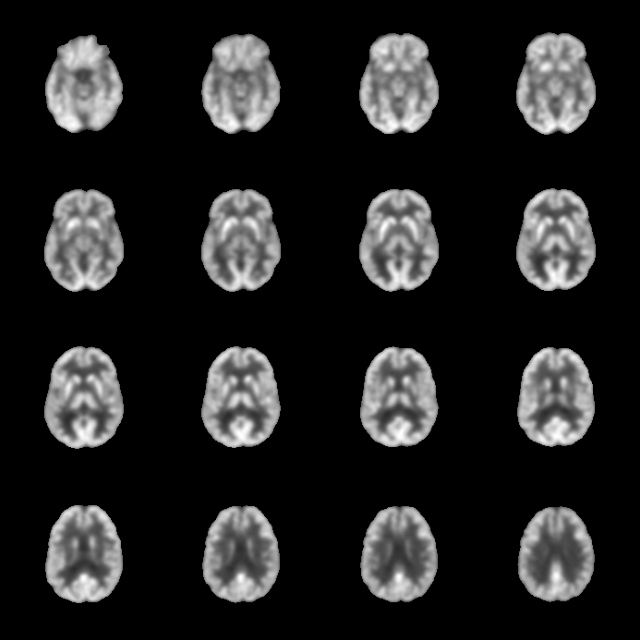

In [73]:
slicesToCut = 0
angle = 15.0 * random.choice([-1, 1])
zoom = 1.0 + 0.1 * random.choice([-1, 1])
shiftX = 10.0 * random.choice([-1, 1])
shiftY = 10.0 * random.choice([-1, 1])
img = transformGridImage3(brain_vol, angle, zoom, shiftX = shiftX, shiftY = shiftY, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 0.0,
                         minSliceSurface = None)
img2 = transformGridImage3(brain_vol, angle, zoom, shiftX = shiftX, shiftY = shiftY, 
                          angleTransformChance = 0.0, zoomTransformChance = 0.0, shiftTransformChance = 0.0,
                         minSliceSurface = 100.0 * 100.0)
img2

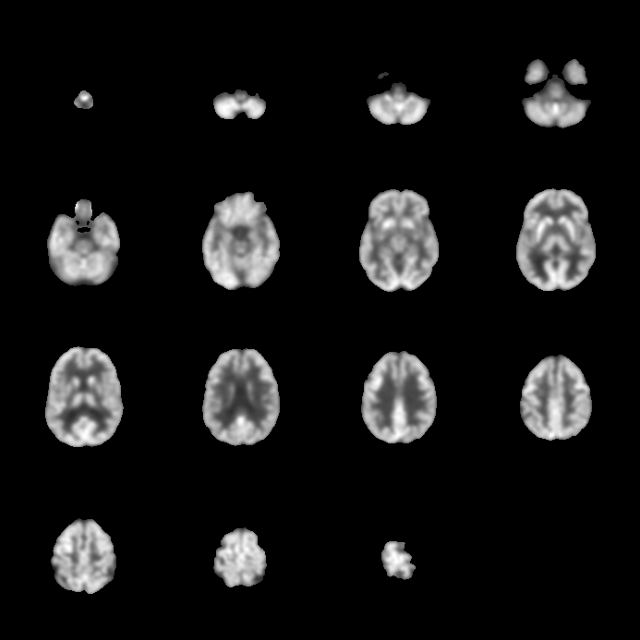

In [74]:
img

## Chequeo superfície de todas las imágenes stripeadas (cuántas no cumplen?)

In [97]:
def hasEnoughSurface(sample, minSliceSurface, pixelSurface = 1.5, minSliceSurfaceThreshold = 0.0):
    brain_vol_data = sample.get_fdata()
    withMoreThan100 = 0
    for i in range(0, brain_vol_data.shape[2]):
            surface = 0.0
            for j in range(0, brain_vol_data.shape[0]):
                    for k in range(0, brain_vol_data.shape[1]):
                            if brain_vol_data[j][k][i] > minSliceSurfaceThreshold:
                                    surface += pixelSurface
            if surface >= minSliceSurface:
                    withMoreThan100 += 1

    return withMoreThan100 >= 16

In [106]:
from sklearn.preprocessing import minmax_scale
def hasEnoughSurfaceStandarized(sample, minSliceSurface, pixelSurface = 1.5, minSliceSurfaceThreshold = 0.0):
    image = sample.get_fdata()
    shape = image.shape
    brain_vol_data = minmax_scale(image.ravel(), feature_range=(0,1000), axis=2).reshape(shape)
    print(brain_vol_data)
    withMoreThan100 = 0
    for i in range(0, brain_vol_data.shape[2]):
            surface = 0.0
            for j in range(0, brain_vol_data.shape[0]):
                    for k in range(0, brain_vol_data.shape[1]):
                            if brain_vol_data[j][k][i] > minSliceSurfaceThreshold:
                                    surface += pixelSurface
            if surface >= minSliceSurface:
                    withMoreThan100 += 1

    return withMoreThan100 >= 16

In [104]:
def checkStrippedImageSurfaces(minSliceSurface, verbose = False, standarized = False):
        enoughSurface = 0
        notEnoughSurface = 0
        images = 0
        files = []
        for file in list(glob.glob('/Users/hugom/My Drive (hugomassaroli@gmail.com)/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped/*.nii')):
                brain_vol = nib.load(file)
                hasEnough = None
                if standarized:
                    hasEnoughSurfaceStandarized(brain_vol, minSliceSurface)
                else:      
                    hasEnough = hasEnoughSurface(brain_vol, minSliceSurface)
                if hasEnough:
                        enoughSurface += 1
                else:
                        notEnoughSurface += 1
                        files.append(os.path.basename(file))
                images += 1
                if verbose:
                        print("Not enough surface: " + str(notEnoughSurface) + "/" + str(images))
                
        print("Enough surface: ")
        print(enoughSurface)
        print("Not enough surface: ")
        print(notEnoughSurface)
        print(files)

In [96]:
checkStrippedImageSurfaces(100.0 * 100.0, verbose = True)

Not enough surface: 0/1
Not enough surface: 0/2
Not enough surface: 0/3
Not enough surface: 0/4
Not enough surface: 0/5
Not enough surface: 0/6
Not enough surface: 0/7
Not enough surface: 0/8
Not enough surface: 0/9
Not enough surface: 0/10
Not enough surface: 0/11
Not enough surface: 0/12
Not enough surface: 0/13
Not enough surface: 0/14
Not enough surface: 0/15
Not enough surface: 1/16
Not enough surface: 1/17
Not enough surface: 2/18
Not enough surface: 2/19
Not enough surface: 2/20
Not enough surface: 2/21
Not enough surface: 2/22
Not enough surface: 2/23
Not enough surface: 2/24
Not enough surface: 2/25
Not enough surface: 2/26
Not enough surface: 2/27
Not enough surface: 2/28
Not enough surface: 2/29
Not enough surface: 2/30
Not enough surface: 2/31
Not enough surface: 2/32
Not enough surface: 2/33
Not enough surface: 2/34
Not enough surface: 2/35
Not enough surface: 2/36
Not enough surface: 2/37
Not enough surface: 2/38
Not enough surface: 2/39
Not enough surface: 2/40
Not enoug

Not enough surface: 9/321
Not enough surface: 9/322
Not enough surface: 9/323
Not enough surface: 9/324
Not enough surface: 9/325
Not enough surface: 9/326
Not enough surface: 9/327
Not enough surface: 9/328
Not enough surface: 9/329
Not enough surface: 9/330
Not enough surface: 9/331
Not enough surface: 9/332
Not enough surface: 9/333
Not enough surface: 9/334
Not enough surface: 9/335
Not enough surface: 9/336
Not enough surface: 9/337
Not enough surface: 9/338
Not enough surface: 9/339
Not enough surface: 9/340
Not enough surface: 9/341
Not enough surface: 9/342
Not enough surface: 9/343
Not enough surface: 9/344
Not enough surface: 9/345
Not enough surface: 9/346
Not enough surface: 9/347
Not enough surface: 9/348
Not enough surface: 9/349
Not enough surface: 9/350
Not enough surface: 9/351
Not enough surface: 9/352
Not enough surface: 9/353
Not enough surface: 9/354
Not enough surface: 9/355
Not enough surface: 9/356
Not enough surface: 9/357
Not enough surface: 9/358
Not enough s

Not enough surface: 20/626
Not enough surface: 20/627
Not enough surface: 20/628
Not enough surface: 21/629
Not enough surface: 21/630
Not enough surface: 21/631
Not enough surface: 21/632
Not enough surface: 21/633
Not enough surface: 21/634
Not enough surface: 21/635
Not enough surface: 21/636
Not enough surface: 21/637
Not enough surface: 21/638
Not enough surface: 21/639
Not enough surface: 21/640
Not enough surface: 21/641
Not enough surface: 21/642
Not enough surface: 21/643
Not enough surface: 21/644
Not enough surface: 21/645
Not enough surface: 21/646
Not enough surface: 21/647
Not enough surface: 21/648
Not enough surface: 21/649
Not enough surface: 21/650
Not enough surface: 21/651
Not enough surface: 21/652
Not enough surface: 21/653
Not enough surface: 21/654
Not enough surface: 21/655
Not enough surface: 21/656
Not enough surface: 21/657
Not enough surface: 21/658
Not enough surface: 21/659
Not enough surface: 21/660
Not enough surface: 21/661
Not enough surface: 21/662
N

Not enough surface: 32/930
Not enough surface: 32/931
Not enough surface: 32/932
Not enough surface: 32/933
Not enough surface: 32/934
Not enough surface: 32/935
Not enough surface: 32/936
Not enough surface: 32/937
Not enough surface: 33/938
Not enough surface: 33/939
Not enough surface: 33/940
Not enough surface: 33/941
Not enough surface: 33/942
Not enough surface: 33/943
Not enough surface: 33/944
Not enough surface: 33/945
Not enough surface: 33/946
Not enough surface: 33/947
Not enough surface: 33/948
Not enough surface: 33/949
Not enough surface: 34/950
Not enough surface: 35/951
Not enough surface: 35/952
Not enough surface: 35/953
Not enough surface: 35/954
Not enough surface: 35/955
Not enough surface: 35/956
Not enough surface: 35/957
Not enough surface: 35/958
Not enough surface: 35/959
Not enough surface: 35/960
Not enough surface: 36/961
Not enough surface: 36/962
Not enough surface: 36/963
Not enough surface: 36/964
Not enough surface: 36/965
Not enough surface: 36/966
N

Not enough surface: 50/1226
Not enough surface: 51/1227
Not enough surface: 51/1228
Not enough surface: 51/1229
Not enough surface: 51/1230
Not enough surface: 51/1231
Not enough surface: 51/1232
Not enough surface: 51/1233
Not enough surface: 51/1234
Not enough surface: 51/1235
Not enough surface: 51/1236
Not enough surface: 51/1237
Not enough surface: 51/1238
Not enough surface: 51/1239
Not enough surface: 51/1240
Not enough surface: 51/1241
Not enough surface: 51/1242
Not enough surface: 51/1243
Not enough surface: 51/1244
Not enough surface: 51/1245
Not enough surface: 51/1246
Not enough surface: 52/1247
Not enough surface: 52/1248
Not enough surface: 52/1249
Not enough surface: 52/1250
Not enough surface: 53/1251
Not enough surface: 53/1252
Not enough surface: 53/1253
Not enough surface: 53/1254
Not enough surface: 53/1255
Not enough surface: 53/1256
Not enough surface: 53/1257
Not enough surface: 53/1258
Not enough surface: 53/1259
Not enough surface: 53/1260
Not enough surface: 

Not enough surface: 64/1519
Not enough surface: 64/1520
Not enough surface: 64/1521
Not enough surface: 64/1522
Not enough surface: 64/1523
Not enough surface: 64/1524
Not enough surface: 64/1525
Not enough surface: 64/1526
Not enough surface: 64/1527
Not enough surface: 64/1528
Not enough surface: 64/1529
Not enough surface: 64/1530
Not enough surface: 64/1531
Not enough surface: 64/1532
Not enough surface: 64/1533
Not enough surface: 64/1534
Not enough surface: 64/1535
Not enough surface: 64/1536
Not enough surface: 64/1537
Not enough surface: 64/1538
Not enough surface: 64/1539
Not enough surface: 65/1540
Not enough surface: 65/1541
Not enough surface: 65/1542
Not enough surface: 65/1543
Not enough surface: 65/1544
Not enough surface: 65/1545
Not enough surface: 65/1546
Not enough surface: 65/1547
Not enough surface: 65/1548
Not enough surface: 66/1549
Not enough surface: 66/1550
Not enough surface: 66/1551
Not enough surface: 66/1552
Not enough surface: 66/1553
Not enough surface: 

Not enough surface: 77/1812
Not enough surface: 77/1813
Not enough surface: 77/1814
Not enough surface: 77/1815
Not enough surface: 77/1816
Not enough surface: 77/1817
Not enough surface: 77/1818
Not enough surface: 77/1819
Not enough surface: 77/1820
Not enough surface: 77/1821
Not enough surface: 77/1822
Not enough surface: 77/1823
Not enough surface: 78/1824
Not enough surface: 78/1825
Not enough surface: 78/1826
Not enough surface: 79/1827
Not enough surface: 79/1828
Not enough surface: 79/1829
Not enough surface: 79/1830
Not enough surface: 79/1831
Not enough surface: 79/1832
Not enough surface: 79/1833
Not enough surface: 79/1834
Not enough surface: 79/1835
Not enough surface: 80/1836
Not enough surface: 80/1837
Not enough surface: 80/1838
Not enough surface: 80/1839
Not enough surface: 80/1840
Not enough surface: 80/1841
Not enough surface: 80/1842
Not enough surface: 81/1843
Not enough surface: 81/1844
Not enough surface: 81/1845
Not enough surface: 81/1846
Not enough surface: 

KeyboardInterrupt: 

In [107]:
checkStrippedImageSurfaces(100.0 * 100.0, verbose = True, standarized = True)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Not enough

KeyboardInterrupt: 

In [108]:
checkStrippedImageSurfaces(95.0 * 95.0, verbose = True)

Not enough surface: 0/1
Not enough surface: 0/2
Not enough surface: 0/3
Not enough surface: 0/4
Not enough surface: 0/5
Not enough surface: 0/6
Not enough surface: 0/7
Not enough surface: 0/8
Not enough surface: 0/9
Not enough surface: 0/10
Not enough surface: 0/11
Not enough surface: 0/12
Not enough surface: 0/13
Not enough surface: 0/14
Not enough surface: 0/15
Not enough surface: 0/16
Not enough surface: 0/17
Not enough surface: 0/18
Not enough surface: 0/19
Not enough surface: 0/20
Not enough surface: 0/21
Not enough surface: 0/22
Not enough surface: 0/23
Not enough surface: 0/24
Not enough surface: 0/25
Not enough surface: 0/26
Not enough surface: 0/27
Not enough surface: 0/28
Not enough surface: 0/29
Not enough surface: 0/30
Not enough surface: 0/31
Not enough surface: 0/32
Not enough surface: 0/33
Not enough surface: 0/34
Not enough surface: 0/35
Not enough surface: 0/36
Not enough surface: 0/37
Not enough surface: 0/38
Not enough surface: 0/39
Not enough surface: 0/40
Not enoug

KeyboardInterrupt: 

In [109]:
checkStrippedImageSurfaces(90.0 * 90.0, verbose = True)

Not enough surface: 0/1
Not enough surface: 0/2
Not enough surface: 0/3
Not enough surface: 0/4
Not enough surface: 0/5
Not enough surface: 0/6
Not enough surface: 0/7
Not enough surface: 0/8
Not enough surface: 0/9
Not enough surface: 0/10
Not enough surface: 0/11
Not enough surface: 0/12
Not enough surface: 0/13
Not enough surface: 0/14
Not enough surface: 0/15
Not enough surface: 0/16
Not enough surface: 0/17
Not enough surface: 0/18
Not enough surface: 0/19
Not enough surface: 0/20
Not enough surface: 0/21
Not enough surface: 0/22
Not enough surface: 0/23
Not enough surface: 0/24
Not enough surface: 0/25
Not enough surface: 0/26
Not enough surface: 0/27
Not enough surface: 0/28
Not enough surface: 0/29
Not enough surface: 0/30
Not enough surface: 0/31
Not enough surface: 0/32
Not enough surface: 0/33
Not enough surface: 0/34
Not enough surface: 0/35
Not enough surface: 0/36
Not enough surface: 0/37
Not enough surface: 0/38
Not enough surface: 0/39
Not enough surface: 0/40
Not enoug

Not enough surface: 0/321
Not enough surface: 0/322
Not enough surface: 0/323
Not enough surface: 0/324
Not enough surface: 0/325
Not enough surface: 0/326
Not enough surface: 0/327
Not enough surface: 0/328
Not enough surface: 0/329
Not enough surface: 0/330
Not enough surface: 0/331
Not enough surface: 0/332
Not enough surface: 0/333
Not enough surface: 0/334
Not enough surface: 0/335
Not enough surface: 0/336
Not enough surface: 0/337
Not enough surface: 0/338
Not enough surface: 0/339
Not enough surface: 0/340
Not enough surface: 0/341
Not enough surface: 0/342
Not enough surface: 0/343
Not enough surface: 0/344
Not enough surface: 0/345
Not enough surface: 0/346
Not enough surface: 0/347
Not enough surface: 0/348
Not enough surface: 0/349
Not enough surface: 0/350
Not enough surface: 0/351
Not enough surface: 0/352
Not enough surface: 0/353
Not enough surface: 0/354
Not enough surface: 0/355
Not enough surface: 0/356
Not enough surface: 0/357
Not enough surface: 0/358
Not enough s

Not enough surface: 0/637
Not enough surface: 0/638
Not enough surface: 0/639
Not enough surface: 0/640
Not enough surface: 0/641
Not enough surface: 0/642
Not enough surface: 0/643
Not enough surface: 0/644
Not enough surface: 0/645
Not enough surface: 0/646
Not enough surface: 0/647
Not enough surface: 0/648
Not enough surface: 0/649
Not enough surface: 0/650
Not enough surface: 0/651
Not enough surface: 0/652
Not enough surface: 0/653
Not enough surface: 0/654
Not enough surface: 0/655
Not enough surface: 0/656
Not enough surface: 0/657
Not enough surface: 0/658
Not enough surface: 0/659
Not enough surface: 0/660
Not enough surface: 0/661
Not enough surface: 0/662
Not enough surface: 0/663
Not enough surface: 0/664
Not enough surface: 0/665
Not enough surface: 0/666
Not enough surface: 0/667
Not enough surface: 0/668
Not enough surface: 0/669
Not enough surface: 0/670
Not enough surface: 0/671
Not enough surface: 0/672
Not enough surface: 0/673
Not enough surface: 0/674
Not enough s

Not enough surface: 0/953
Not enough surface: 0/954
Not enough surface: 0/955
Not enough surface: 0/956
Not enough surface: 0/957
Not enough surface: 0/958
Not enough surface: 0/959
Not enough surface: 0/960
Not enough surface: 0/961
Not enough surface: 0/962
Not enough surface: 0/963
Not enough surface: 0/964
Not enough surface: 0/965
Not enough surface: 0/966
Not enough surface: 0/967
Not enough surface: 0/968
Not enough surface: 0/969
Not enough surface: 0/970
Not enough surface: 0/971
Not enough surface: 0/972
Not enough surface: 0/973
Not enough surface: 0/974
Not enough surface: 0/975
Not enough surface: 0/976
Not enough surface: 0/977
Not enough surface: 0/978
Not enough surface: 0/979
Not enough surface: 0/980
Not enough surface: 0/981
Not enough surface: 0/982
Not enough surface: 0/983
Not enough surface: 0/984
Not enough surface: 0/985
Not enough surface: 0/986
Not enough surface: 0/987
Not enough surface: 0/988
Not enough surface: 0/989
Not enough surface: 0/990
Not enough s

Not enough surface: 0/1259
Not enough surface: 0/1260
Not enough surface: 0/1261
Not enough surface: 0/1262
Not enough surface: 0/1263
Not enough surface: 0/1264
Not enough surface: 0/1265
Not enough surface: 0/1266
Not enough surface: 0/1267
Not enough surface: 0/1268
Not enough surface: 0/1269
Not enough surface: 0/1270
Not enough surface: 0/1271
Not enough surface: 0/1272
Not enough surface: 0/1273
Not enough surface: 0/1274
Not enough surface: 0/1275
Not enough surface: 0/1276
Not enough surface: 0/1277
Not enough surface: 0/1278
Not enough surface: 0/1279
Not enough surface: 0/1280
Not enough surface: 0/1281
Not enough surface: 0/1282
Not enough surface: 0/1283
Not enough surface: 0/1284
Not enough surface: 0/1285
Not enough surface: 0/1286
Not enough surface: 0/1287
Not enough surface: 0/1288
Not enough surface: 0/1289
Not enough surface: 0/1290
Not enough surface: 0/1291
Not enough surface: 0/1292
Not enough surface: 0/1293
Not enough surface: 0/1294
Not enough surface: 0/1295
N

Not enough surface: 0/1563
Not enough surface: 0/1564
Not enough surface: 0/1565
Not enough surface: 0/1566
Not enough surface: 0/1567
Not enough surface: 0/1568
Not enough surface: 0/1569
Not enough surface: 0/1570
Not enough surface: 0/1571
Not enough surface: 0/1572
Not enough surface: 0/1573
Not enough surface: 0/1574
Not enough surface: 0/1575
Not enough surface: 0/1576
Not enough surface: 0/1577
Not enough surface: 0/1578
Not enough surface: 0/1579
Not enough surface: 0/1580
Not enough surface: 0/1581
Not enough surface: 0/1582
Not enough surface: 0/1583
Not enough surface: 0/1584
Not enough surface: 0/1585
Not enough surface: 0/1586
Not enough surface: 0/1587
Not enough surface: 0/1588
Not enough surface: 0/1589
Not enough surface: 0/1590
Not enough surface: 0/1591
Not enough surface: 0/1592
Not enough surface: 0/1593
Not enough surface: 0/1594
Not enough surface: 0/1595
Not enough surface: 0/1596
Not enough surface: 0/1597
Not enough surface: 0/1598
Not enough surface: 0/1599
N

Not enough surface: 0/1867
Not enough surface: 0/1868
Not enough surface: 0/1869
Not enough surface: 0/1870
Not enough surface: 0/1871
Not enough surface: 0/1872
Not enough surface: 0/1873
Not enough surface: 0/1874
Not enough surface: 0/1875
Not enough surface: 0/1876
Not enough surface: 0/1877
Not enough surface: 0/1878
Not enough surface: 0/1879
Not enough surface: 0/1880
Not enough surface: 0/1881
Not enough surface: 0/1882
Not enough surface: 0/1883
Not enough surface: 0/1884
Not enough surface: 0/1885
Not enough surface: 0/1886
Not enough surface: 0/1887
Not enough surface: 0/1888
Not enough surface: 0/1889
Not enough surface: 0/1890
Not enough surface: 0/1891
Not enough surface: 0/1892
Not enough surface: 0/1893
Not enough surface: 0/1894
Not enough surface: 0/1895
Not enough surface: 0/1896
Not enough surface: 0/1897
Not enough surface: 0/1898
Not enough surface: 0/1899
Not enough surface: 0/1900
Not enough surface: 0/1901
Not enough surface: 0/1902
Not enough surface: 0/1903
N

Not enough surface: 0/2171
Not enough surface: 0/2172
Not enough surface: 0/2173
Not enough surface: 0/2174
Not enough surface: 0/2175
Not enough surface: 0/2176
Not enough surface: 0/2177
Not enough surface: 0/2178
Not enough surface: 0/2179
Not enough surface: 0/2180
Not enough surface: 0/2181
Not enough surface: 0/2182
Not enough surface: 0/2183
Not enough surface: 0/2184
Not enough surface: 0/2185
Not enough surface: 0/2186
Not enough surface: 0/2187
Not enough surface: 0/2188
Not enough surface: 0/2189
Not enough surface: 0/2190
Not enough surface: 0/2191
Not enough surface: 0/2192
Not enough surface: 0/2193
Not enough surface: 0/2194
Not enough surface: 0/2195
Not enough surface: 0/2196
Not enough surface: 0/2197
Not enough surface: 0/2198
Not enough surface: 0/2199
Not enough surface: 0/2200
Not enough surface: 0/2201
Not enough surface: 0/2202
Not enough surface: 0/2203
Not enough surface: 0/2204
Not enough surface: 0/2205
Not enough surface: 0/2206
Not enough surface: 0/2207
N

# Nueva función de imágenes

In [6]:
class TransformGridImage():
    def __init__(self, angle = None, zoom = None, shiftX = None, shiftY = None, angleTransformChance = 0.1, zoomTransformChance = 0.1, shiftTransformChance = 0.1):
      self.angle = angle
      self.zoom = zoom
      self.shiftX = shiftX
      self.shiftY = shiftY
      self.angleTransformChance = angleTransformChance
      self.zoomTransformChance = zoomTransformChance
      self.shiftTransformChance = shiftTransformChance

    def __call__(self, studyData):
      sample = studyData[0]
      metadata = studyData[1]

      brain_vol_data = sample.get_fdata()
      fig_rows = 4
      fig_cols = 4
      n_subplots = fig_rows * fig_cols

      deleteIndices = metadata["deleteIndices"]
    
      brain_vol_data = np.delete(brain_vol_data, deleteIndices, axis=2)
    
      n_slice = brain_vol_data.shape[2]

      step_size = n_slice / n_subplots

      slice_indices = np.arange(0, n_slice, step = step_size)

      channels = 3
      grid = np.empty( shape = (fig_rows * 128, fig_cols * 128, channels), dtype=np.float32)
      
      angle = self.angle
      zoom = self.zoom
      shiftX = self.shiftX
      shiftY = self.shiftY

      if self.angle == None or self.angleTransformChance < random.uniform(0.0, 1.0):
        angle = 0.0 # Disable random angle
        
      if self.zoom != None and random.uniform(0.0, 1.0) > self.zoomTransformChance:
        zoom = None
        
      if self.shiftX != None and random.uniform(0.0, 1.0) > self.shiftTransformChance:
        shiftX = None
        
      if self.shiftY != None and random.uniform(0.0, 1.0) > self.shiftTransformChance:
        shiftY = None
        
      slice_index = 0
      for i in range(0, fig_rows):
        for j in range(0, fig_cols):
            slice_index  = slice_indices[i * fig_rows + j]
            processedImage = ndi.rotate(brain_vol_data[:, :, round(slice_index)], 90.0 + angle, mode='nearest', reshape = False)

            if zoom != None:
                processedImage = clipped_zoom(processedImage, zoom, mode = 'nearest')

            if shiftX != None:
                processedImage = ndi.shift(processedImage, [0.0, shiftX], mode = 'nearest')

            if shiftY != None:
                processedImage = ndi.shift(processedImage, [shiftY, 0.0], mode = 'nearest')

            rowStart = i * 128
            rowEnd = (i + 1) * 128
            colStart = j * 128
            colEnd = (j+1)*128
            
            # 3 channels
            for c in range(0, channels):
              grid[rowStart:rowEnd, colStart:colEnd, c] = processedImage.copy()

            slice_index += 1

      return grid


In [181]:
import json
brain_vol = nib.load('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I28833/resampled-normalized.nii')
fMetadata = open('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I28833/metadata.json')
metadata = json.load(fMetadata)
fMetadata.close()

FileNotFoundError: No such file or no access: '/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I28833/resampled-normalized.nii'

In [185]:
transform = TransformGridImage(angle = 10, angleTransformChance = 1.0, zoom = 0.7, zoomTransformChance = 1.0)
image2 = transform([brain_vol, metadata])

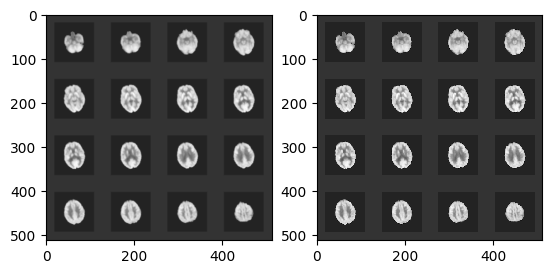

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Make an array with ones in the shape of an 'X'
a = image2[:, :, 0]

fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a, interpolation='bilinear', cmap=cm.Greys_r)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

(0.1, 0.1)


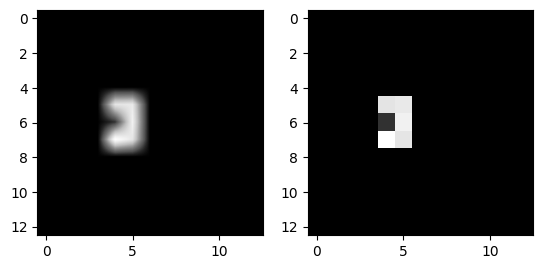

In [200]:
img = brain_vol.get_fdata()[:,:,5]
zoom_tuple = (0.1,) * 2 + (1,) * (img.ndim - 2)
print(zoom_tuple)
newimg = ndi.zoom(img, zoom_tuple, mode = 'nearest')
newimg

a = newimg
fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a, interpolation='bilinear', cmap=cm.Greys_r)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

In [4]:
import json
brain_vol = nib.load('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3/98e82e34-df3aa054-551be0aa-6ff6d7c9-6ce792a9/resampled-normalized.nii')
fMetadata = open('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3/98e82e34-df3aa054-551be0aa-6ff6d7c9-6ce792a9/metadata.json')
metadata = json.load(fMetadata)
fMetadata.close()

In [9]:
transform = TransformGridImage(angle = 10, angleTransformChance = 1.0, zoom = 0.7, zoomTransformChance = 1.0)
image2 = transform([brain_vol, metadata])

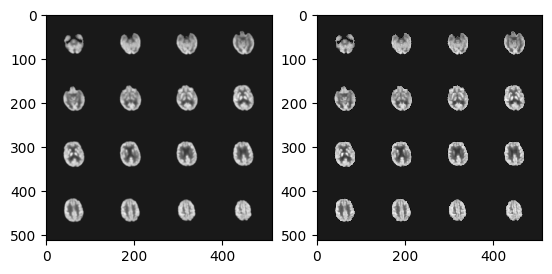

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Make an array with ones in the shape of an 'X'
a = image2[:, :, 0]

fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a, interpolation='bilinear', cmap=cm.Greys_r)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

# Nueva testeo imágenes

In [47]:
class TransformGridImage():
    def __init__(self, angle = None, zoom = None, shiftX = None, shiftY = None, shear = None):
      self.angle = angle
      self.zoom = zoom
      self.shiftX = shiftX
      self.shiftY = shiftY
      self.shear = shear
      self.sliceWidth = 128
      self.sliceHeight = 128
      self.filters = [None]
      if (self.zoom):
        self.filters.append("zoom")
      if (self.angle):
        self.filters.append("angle")
      if self.shiftX:
        self.filters.append("shiftX")
      if self.shiftY:
        self.filters.append("shiftY")
      if self.shear:
        self.filters.append("shear")

    def __call__(self, studyData):
      sample = studyData[0]
      metadata = studyData[1]

      brain_vol_data = sample.get_fdata()
      fig_rows = 4
      fig_cols = 4
      n_subplots = fig_rows * fig_cols

      deleteIndices = metadata["deleteIndices"]
    
      brain_vol_data = np.delete(brain_vol_data, deleteIndices, axis=2)
    
      n_slice = brain_vol_data.shape[2]

      step_size = n_slice / n_subplots

      slice_indices = np.arange(0, n_slice, step = step_size)

      channels = 3
      grid = np.empty( shape = (fig_rows * 128, fig_cols * 128, channels), dtype=np.float32)
      
      filter = random.choice(self.filters)
        
      print(filter)
      angle = 0.0
      zoom = None
      shiftX = None
      shiftY = None
      shear = None
    
      if filter == "angle":
        angle = random.uniform(-self.angle, self.angle)
      elif filter == "zoom":
        zoom = 1.0 + random.uniform(-self.zoom, self.zoom)
      elif filter == "shiftX":
        shiftX = round(128 * random.uniform(-self.shiftX, self.shiftX) / 100.0)
      elif self.shiftY == "shiftY":
        shiftY = round(128 * random.uniform(-self.shiftY, self.shiftY) / 100.0)
      elif filter == "shear":
        shear = random.uniform(-self.shear, self.shear)
        
      slice_index = 0
      for i in range(0, fig_rows):
        for j in range(0, fig_cols):
            slice_index  = slice_indices[i * fig_rows + j]
            processedImage = ndi.rotate(brain_vol_data[:, :, round(slice_index)], 90.0 + angle, mode='nearest', reshape = False)

            if zoom != None:
                processedImage = clipped_zoom(processedImage, zoom, mode = 'nearest')

            if shiftX != None:
                processedImage = ndi.shift(processedImage, [0.0, shiftX], mode = 'nearest')

            if shiftY != None:
                processedImage = ndi.shift(processedImage, [shiftY, 0.0], mode = 'nearest')

            if shear != None:
                # shear debe estar en radianes
                # https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py#L348
                transform = np.array([[1, -np.sin(shear), 0],
                                 [0, np.cos(shear), 0],
                                 [0, 0, 1]])
                processedImage = ndi.affine_transform(processedImage,
                    transform,
                    #offset=(0, -self.sliceHeight//2, 0),
                    output_shape=(self.sliceWidth, self.sliceHeight))

            rowStart = i * 128
            rowEnd = (i + 1) * 128
            colStart = j * 128
            colEnd = (j+1)*128
            
            # 3 channels
            for c in range(0, channels):
              grid[rowStart:rowEnd, colStart:colEnd, c] = processedImage.copy()

            slice_index += 1

      return grid

In [48]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
brain_vol = nib.load('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3/98e82e34-df3aa054-551be0aa-6ff6d7c9-6ce792a9/resampled-normalized.nii')
fMetadata = open('/Users/hugom/Tesis/Imagenes/fleni-stripped-preprocessed3/98e82e34-df3aa054-551be0aa-6ff6d7c9-6ce792a9/metadata.json')
metadata = json.load(fMetadata)
fMetadata.close()

shear


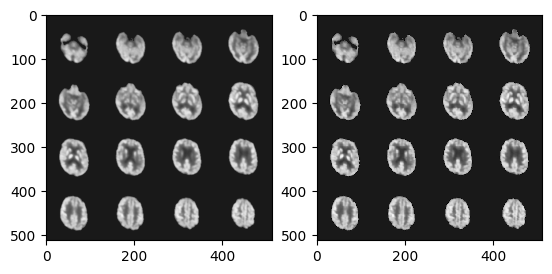

In [49]:
transform = TransformGridImage(shear = np.pi / 8)
image2 = transform([brain_vol, metadata])


# Make an array with ones in the shape of an 'X'
a = image2[:, :, 0]

fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(a, interpolation='bilinear', cmap=cm.Greys_r)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(a, interpolation='nearest', cmap=cm.Greys_r)

plt.show()

# Testeo resample nifti non isomorphic

In [34]:
# Ídem resample nifti pero tiene un target shape específico para cada dimensión
def resampleNiftiNonIsomorphic(sample, scaleX = 1, scaleY = 1, scaleZ = 1):
    currX = sample.header['dim'][1]
    currY = sample.header['dim'][2]
    currZ = sample.header['dim'][3]
    
    scaleAffine = np.array([
        [scaleX, 0, 0, 0],
        [0, scaleY, 0, 0],
        [0, 0, scaleZ, 0],
   
        [0, 0, 0, 1],
    ])
    newAffine =  sample.affine @ scaleAffine
    # Usamos nearest porque es mas fiel, no inventa valores, aunque se vea peor
    resampled = resample_img(sample, copy = True, target_affine=newAffine, interpolation='nearest')
    return resampled

In [35]:
brain_vol = nib.load('/Users/hugom/Tesis/Imagenes/ADNI-MUESTRA-FULL-stripped-preprocessed3/I28833/resampled-normalized.nii')


In [36]:
print(brain_vol.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  77   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.    1.875 1.875 1.875 1.    1.    1.    1.   ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 160.0
qoffset_y       : 160.0
qoffset_z       : 1.5
srow_x          : [  1.875 

In [47]:
brain_vol2 = resampleNiftiNonIsomorphic(brain_vol, scaleZ = 1.660)

In [48]:
print(brain_vol2.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 128 128  47   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.     1.875  1.875  3.1125 1.     1.     1.     1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 160.0
qoffset_y       : 160.0
qoffset_z       : 1.5
srow_x          : [

In [32]:
nib.save(brain_vol, './non-resampled.nii')

In [33]:
nib.save(brain_vol2, './resampled-non-isomorphic.nii')